# Notebook for Exploring Explainable AI in a Physics Setting

In this notebook we explore how SHAP explainability deals with a physical system like the Duffing Oscillator

In [1]:
"""
Import Libraries
"""
# General Libraries
import numpy as np
import pandas as pd
import os

# True Model
from scipy.integrate import odeint
from scipy.fft import fft

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import Sequence
from tensorflow import keras


# Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

# Plotting Libraries
import matplotlib.pylab as plt
import seaborn as sns

# Explainability
import lime
import shap

# Set Seaborn Theme
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)


In [2]:
"""
Choose the training data set to be trained on.

For general datasets use custom suffix.
"""
suffix = "delta03_irrelevant"#"delayed_traj_delta03"

X_train = pd.read_csv("Data/X_train_"+suffix+".csv", header=0, index_col=0)
y_train = pd.read_csv("Data/y_train_"+suffix+".csv", header=0, index_col=0)
X_test = pd.read_csv("Data/X_test_"+suffix+".csv", header=0, index_col=0)
y_test = pd.read_csv("Data/y_test_"+suffix+".csv", header=0, index_col=0)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [3]:
"""
f, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4]))

sns.scatterplot(data = y_test.iloc[:10000,:], x = 'xt', y='vt', ax=axs, marker='x', linewidth = 1)

axs.set(xlim=(-2, 2), ylim=(-2, 2))
axs.set_xlabel('x [ ]')
axs.set_ylabel('v [ ]')
axs.set_title("Phase Space Plot")

f.tight_layout()

f.savefig("Images/data_only_"+suffix+".svg", dpi='figure')

f, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4]))

sns.scatterplot(data = X_test.iloc[:10000,:], x = 'x0', y='v0', ax=axs, marker='x', linewidth = 1)
axs.set(xlim=(-2, 2), ylim=(-2, 2))
axs.set_xlabel('x [ ]')
axs.set_ylabel('v [ ]')
axs.set_title("Phase Space Plot")

f.tight_layout()

f.savefig("Images/data_only_"+suffix+".svg", dpi='figure')
"""

'\nf, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4]))\n\nsns.scatterplot(data = y_test.iloc[:10000,:], x = \'xt\', y=\'vt\', ax=axs, marker=\'x\', linewidth = 1)\n\naxs.set(xlim=(-2, 2), ylim=(-2, 2))\naxs.set_xlabel(\'x [ ]\')\naxs.set_ylabel(\'v [ ]\')\naxs.set_title("Phase Space Plot")\n\nf.tight_layout()\n\nf.savefig("Images/data_only_"+suffix+".svg", dpi=\'figure\')\n\nf, axs = plt.subplots(1, 1, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4]))\n\nsns.scatterplot(data = X_test.iloc[:10000,:], x = \'x0\', y=\'v0\', ax=axs, marker=\'x\', linewidth = 1)\naxs.set(xlim=(-2, 2), ylim=(-2, 2))\naxs.set_xlabel(\'x [ ]\')\naxs.set_ylabel(\'v [ ]\')\naxs.set_title("Phase Space Plot")\n\nf.tight_layout()\n\nf.savefig("Images/data_only_"+suffix+".svg", dpi=\'figure\')\n'

## Preprocess

Optional data preprocessing step, fourier transform.

Scale the data to 0 mean and unit variance, this is mainly done to improve the neural network's performance but also ensures that magnitude differences between the features have no impact on explainability.

In [4]:
"""
from scipy.fft import fft, fftfreq, fftshift


fft(X_test.values)

t = np.arange(250)

sp = fftshift(fft(X_test.values[:250,:]))

freq = fftshift(fftfreq(t.shape[-1]))

plt.plot(freq, sp.real, freq, sp.imag, 'x')

plt.show()
"""

"\nfrom scipy.fft import fft, fftfreq, fftshift\n\n\nfft(X_test.values)\n\nt = np.arange(250)\n\nsp = fftshift(fft(X_test.values[:250,:]))\n\nfreq = fftshift(fftfreq(t.shape[-1]))\n\nplt.plot(freq, sp.real, freq, sp.imag, 'x')\n\nplt.show()\n"

In [5]:


scaler = StandardScaler()


scaler.fit(X_train.values)
scaler.transform(X_train.values, copy=False)
scaler.transform(X_test.values, copy = False)

#anova_svm = make_pipeline(scaler, model)
#anova_svm.fit(X_train, y_train)

array([[ 1.04319092,  0.93961132, -1.72859016, -1.62930643],
       [ 1.04319092,  0.93961132, -1.72166195, -1.64075495],
       [ 1.04319092,  0.93961132, -1.71473373,  0.24451679],
       ...,
       [-0.48312732,  1.15706225,  1.71473373, -0.03618697],
       [-0.48312732,  1.15706225,  1.72166195,  1.10152985],
       [-0.48312732,  1.15706225,  1.72859016,  0.77200887]])

## Network Training

Here we set up the neural network. We are using a large batch size (5096) to speed up training. Data are shuffled before training because we are using a method to generate the data that causes codependence in adjacent training samples as they belong to the same trajectory. Early stopping criteria are there to stop overfitting though this has rarely been a problem in this setting.

The network architecture makes use of a lot of dense (fully connected) layers. This leads to a large number of trainable parameters so care should be taken to ensure that the dataset is large enough to prevent overfitting being a viable strategy.

As a validation set we use 20% of the training data.

We make use of the Adam optimiser. Using a learning rate of 0.001 seems to work, greater learning rates cause the network to not learn at all and a smaller learning rate slows learning unnecessarily.

In [6]:
"""
Define and Create Model
"""

def MLModel():
    opt = Adam(learning_rate=0.001, beta_1=0.7)
    loss='mse'
    model = Sequential([
        layers.Flatten(),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='sigmoid'),
        layers.Dense(32, activation='tanh'),
        layers.Dense(2)            
    ])
    model.compile(optimizer=opt, loss=loss)
    return model

# Create a basic model instance
model = MLModel()

In [8]:
# Model Weights Path
checkpoint_path = "Networks/training"+suffix+"cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [9]:
"""
Train Model
"""
#model.build()
# Display the model's architecture
#model.summary()



# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks = [cp_callback,
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)]

pipe = make_pipeline(scaler, model)

history=model.fit(X_train, y_train, steps_per_epoch=None, epochs=500, 
                  validation_split=0.2, batch_size=20364, shuffle=True, callbacks=callbacks, verbose=1)

loss = model.evaluate(X_test, y_test, verbose=1)
print("Trained model, loss: {:5.2f}%".format(loss))

Epoch 1/500
1965/1965 [==============================] - 241s 121ms/step - loss: 0.3489 - val_loss: 0.2919

Epoch 00001: saving model to Networks\trainingdelta03_irrelevantcp.ckpt
Epoch 2/500
1965/1965 [==============================] - 236s 120ms/step - loss: 0.2687 - val_loss: 0.2588

Epoch 00002: saving model to Networks\trainingdelta03_irrelevantcp.ckpt
Epoch 3/500
1965/1965 [==============================] - 237s 120ms/step - loss: 0.2453 - val_loss: 0.2435

Epoch 00003: saving model to Networks\trainingdelta03_irrelevantcp.ckpt
Epoch 4/500
1965/1965 [==============================] - 237s 120ms/step - loss: 0.2333 - val_loss: 0.2448

Epoch 00004: saving model to Networks\trainingdelta03_irrelevantcp.ckpt
Epoch 5/500
1965/1965 [==============================] - 235s 120ms/step - loss: 0.2257 - val_loss: 0.2294

Epoch 00005: saving model to Networks\trainingdelta03_irrelevantcp.ckpt
Epoch 6/500
1965/1965 [==============================] - 235s 120ms/step - loss: 0.2197 - val_loss: 

1965/1965 [==============================] - 241s 123ms/step - loss: 0.1716 - val_loss: 0.1795

Epoch 00046: saving model to Networks\trainingdelta03_irrelevantcp.ckpt
Epoch 47/500
1965/1965 [==============================] - 241s 123ms/step - loss: 0.1712 - val_loss: 0.1855

Epoch 00047: saving model to Networks\trainingdelta03_irrelevantcp.ckpt
Epoch 48/500
1965/1965 [==============================] - 241s 123ms/step - loss: 0.1708 - val_loss: 0.1813

Epoch 00048: saving model to Networks\trainingdelta03_irrelevantcp.ckpt
Epoch 49/500
1965/1965 [==============================] - 241s 122ms/step - loss: 0.1705 - val_loss: 0.1895

Epoch 00049: saving model to Networks\trainingdelta03_irrelevantcp.ckpt
Epoch 50/500
1965/1965 [==============================] - 240s 122ms/step - loss: 0.1701 - val_loss: 0.1822

Epoch 00050: saving model to Networks\trainingdelta03_irrelevantcp.ckpt
Epoch 51/500
1965/1965 [==============================] - 241s 122ms/step - loss: 0.1698 - val_loss: 0.1813


TypeError: cannot unpack non-iterable float object

In [9]:
"""
Load Model
"""
# Evaluate the model
loss = model.evaluate(X_test, y_test, verbose=2)
print("Untrained model, loss: {:5.2f}%".format(loss))

# Loads the weights
model.load_weights(checkpoint_path)

# Re-evaluate the model
loss = model.evaluate(X_test, y_test, verbose=1)
print("Trained model, loss: {:5.2f}%".format(loss))

15625/15625 - 10s - loss: 1.0985
Untrained model, loss:  1.10%
15625/15625 [==============================] - 11s 695us/step - loss: 0.1784
Trained model, loss:  0.18%


In [10]:
class TrueModel():
    """
    Class to represent the True Model of the Duffing oscillator.
    Uses the scipy odeint integrator to perform time evolution.
    
    Methods:
    -----------
    predict(X):
        Inputs:
        --------
        X: pandas DataFrame with at least columns x0,v0,t
        Returns:
        --------
        y: pandas DataFrame with columns xt,vt
    """
    def __init__(self, scaler):
        self.alpha=-1
        self.beta=1
        self.delta=1#0.3
        self.gamma=0.37
        self.omega=1.2
        self.scaler = scaler
        
    def eom(self, u, t):
        x, dx = u[0], u[1]
        ddx= self.gamma * np.cos(self.omega * t) - (self.delta * dx + self.alpha*x + self.beta * x**3)
        return [dx,ddx]
    
    def predict(self, X):
        X = pd.DataFrame(self.scaler.inverse_transform(X), columns=['x0','v0','t','r'])
        y = np.ones((np.shape(X)[0], 2))
        for i in range(0,np.shape(X)[0]):
            t_range = np.linspace(0, X['t'].iloc[i], 500, endpoint=False)
            y[i,:] = odeint(self.eom, [X['x0'].iloc[i],X['v0'].iloc[i]], t_range)[-1]
        y = pd.DataFrame(y, columns=['xt','vt'])    
        return y


## Evaluation and Visualisation of Results:

To be able to visualise the error we remove outliers (top 5% of absolute error). This ensures that the rare misclassifications don't drag the x-axis of our error plot out too far.



In [11]:
# evaluate the fitting validation and training losses
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

## Make Prdictions on the Test Dataset
y_pred = pd.DataFrame(model.predict(X_test), columns=['xt','vt'])

pred_norm = np.linalg.norm(y_pred[['xt','vt']].values,axis=1)
true_norm = np.linalg.norm(y_test[['xt','vt']].values,axis=1)
hist_data = np.abs(pred_norm-true_norm)/np.abs(true_norm)
hist_data = pd.DataFrame(hist_data, columns=['norm'])

def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.00)
    Q3 = df.quantile(0.95)
    IQR = Q3 - Q1
    trueList = ~((df > (Q3 + 1.5 * IQR)))
    #trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

indices = Remove_Outlier_Indices(hist_data)
hist_data = hist_data[indices]

NameError: name 'history' is not defined

You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
You passed a edgecolor/edgecolors ('w') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


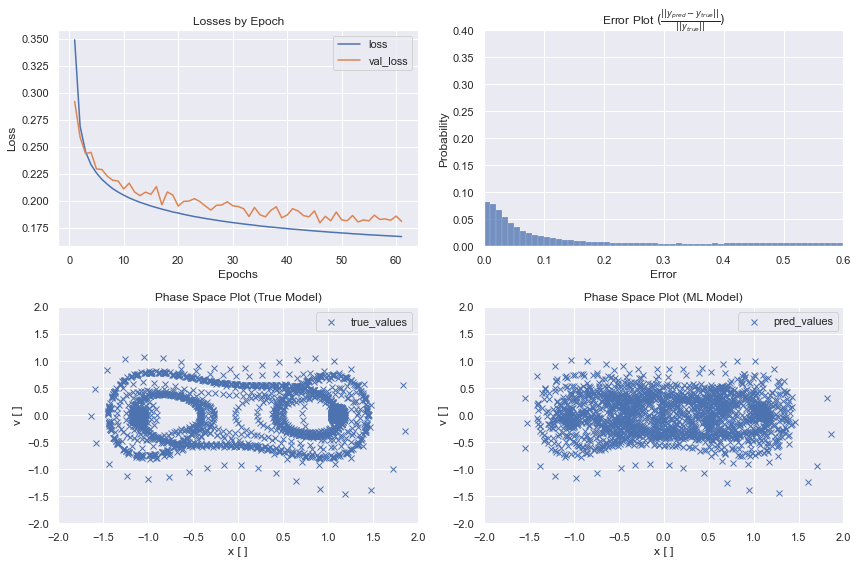

In [14]:
# Loss Plot ML Model
f, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4, 4]))

sns.lineplot(data = history.history, x = epochs, y='loss',ax=axs[0,0], label='loss')
sns.lineplot(data = history.history, x = epochs, y='val_loss',ax=axs[0,0], label='val_loss')

axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title("Losses by Epoch")
axs[0,0].legend()

# Error Plot for ML Predictions
sns.histplot(data=hist_data, x = 'norm', kde=False, stat='probability', binwidth=0.01, ax=axs[0,1])

axs[0,1].set(xlim=(0, 0.6), ylim=(0, 0.4))
axs[0,1].set_xlabel('Error')
axs[0,1].set_ylabel('Probability')
axs[0,1].set_title(r"Error Plot $(\frac{||y_{pred}-y_{true}||}{||y_{true}||})$")

# True Values Plot
sns.scatterplot(data = y_test.iloc[:2000,:], x = 'xt', y='vt',ax=axs[1,0],label='true_values', marker='x', linewidth = 1)

axs[1,0].set(xlim=(-2, 2), ylim=(-2, 2))
axs[1,0].set_xlabel('x [ ]')
axs[1,0].set_ylabel('v [ ]')
axs[1,0].set_title("Phase Space Plot (True Model)")

# ML Values Plot
sns.scatterplot(data = y_pred.iloc[:2000,:], x='xt', y='vt',ax=axs[1,1],label='pred_values',  marker='x', linewidth = 1)

axs[1,1].set(xlim=(-2, 2), ylim=(-2, 2))
axs[1,1].set_xlabel('x [ ]')
axs[1,1].set_ylabel('v [ ]')
axs[1,1].set_title("Phase Space Plot (ML Model)")

f.tight_layout()

f.savefig("Images/model_summary"+suffix+".svg", dpi='figure')

In [15]:
true_model = TrueModel(scaler)

shap.sample(data, K)

kernel_model_x0 = shap.KernelExplainer(model.predict, background)
kernel_model_values_x0 = kernel_model_x0.shap_values(shap_data_good)

background = shap.sample(X_train, 100)
#background = X_train.iloc[np.random.choice(X_train.shape[0], 100000, replace=False)]
shap_data = X_test.iloc[np.random.choice(X_test.shape[0], 10000, replace=False)]

kernel_model_x0 = shap.KernelExplainer(model.predict, background)
kernel_model_values_x0 = kernel_model_x0.shap_values(shap_data_good)
true_explainer_partition = shap.explainers.Partition(true_model.predict, background)
explainer_partition = shap.explainers.Partition(model.predict, background)

In [91]:
true_model = TrueModel(scaler)

background = shap.sample(X_train, 100)

kernel_model = shap.KernelExplainer(model.predict, background)
kernel_true = shap.KernelExplainer(true_model.predict, background)

### Ordered 

Lets choose a spectrum of values that have similar v0 and t whilst x0 varies from -2 to 2:


In [92]:
vals = np.abs(np.linalg.norm(model.predict(X_test), axis=1)- np.linalg.norm(y_test, axis=1))

X_test_good = X_test.iloc[np.where(vals < 0.001)]


shap_data_x0 = X_test_good.sort_values(by='x0').iloc[np.where(np.multiply(np.abs(scaler.inverse_transform(X_test)[:,1])<0.2,
                                                                        np.abs(scaler.inverse_transform(X_test)[:,2]-50)<5))]
shap_choice_x0 = shap_data_x0.iloc[np.sort(np.random.choice(shap_data_x0.shape[0], 100, replace=False))]
shap_choice_x0 = pd.DataFrame(shap_choice_x0.values, columns = X_test.columns)


shap_data_v0 = X_test_good.sort_values(by='v0').iloc[np.where(np.multiply(np.abs(scaler.inverse_transform(X_test)[:,0])<0.5,
                                                                        np.abs(scaler.inverse_transform(X_test)[:,2]-50)<5))]
shap_choice_v0 = shap_data_v0.iloc[np.sort(np.random.choice(shap_data_v0.shape[0], 100, replace=False))]
shap_choice_v0 = pd.DataFrame(shap_choice_v0.values, columns = X_test.columns)


shap_data_t = X_test_good.sort_values(by='t').iloc[np.where(np.multiply(np.abs(scaler.inverse_transform(X_test)[:,1])<0.2,
                                                                        np.abs(scaler.inverse_transform(X_test)[:,0])<0.5))]
shap_choice_t = shap_data_t.iloc[np.sort(np.random.choice(shap_data_t.shape[0], 100, replace=False))]
shap_choice_t = pd.DataFrame(shap_choice_t.values, columns = X_test.columns)

In [93]:
sorted_true_values_x0 = kernel_true.shap_values(shap_choice_x0)
sorted_model_values_x0 = kernel_model.shap_values(shap_choice_x0)

sorted_true_values_v0 = kernel_true.shap_values(shap_choice_v0)
sorted_model_values_v0 = kernel_model.shap_values(shap_choice_v0)

sorted_true_values_t = kernel_true.shap_values(shap_choice_t)
sorted_model_values_t = kernel_model.shap_values(shap_choice_t)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [94]:
true_plot_data_x0_xt = pd.DataFrame(sorted_true_values_x0[0], columns = X_test.columns)

true_plot_data_v0_xt = pd.DataFrame(sorted_true_values_v0[0], columns = X_test.columns)

true_plot_data_t_xt = pd.DataFrame(sorted_true_values_t[0], columns = X_test.columns)

true_plot_data_x0_vt = pd.DataFrame(sorted_true_values_x0[1], columns = X_test.columns)

true_plot_data_v0_vt = pd.DataFrame(sorted_true_values_v0[1], columns = X_test.columns)

true_plot_data_t_vt = pd.DataFrame(sorted_true_values_t[1], columns = X_test.columns)


model_plot_data_x0_xt = pd.DataFrame(sorted_model_values_x0[0], columns = X_test.columns)

model_plot_data_v0_xt = pd.DataFrame(sorted_model_values_v0[0], columns = X_test.columns)

model_plot_data_t_xt = pd.DataFrame(sorted_model_values_t[0], columns = X_test.columns)

model_plot_data_x0_vt = pd.DataFrame(sorted_model_values_x0[1], columns = X_test.columns)

model_plot_data_v0_vt = pd.DataFrame(sorted_model_values_v0[1], columns = X_test.columns)

model_plot_data_t_vt = pd.DataFrame(sorted_model_values_t[1], columns = X_test.columns)

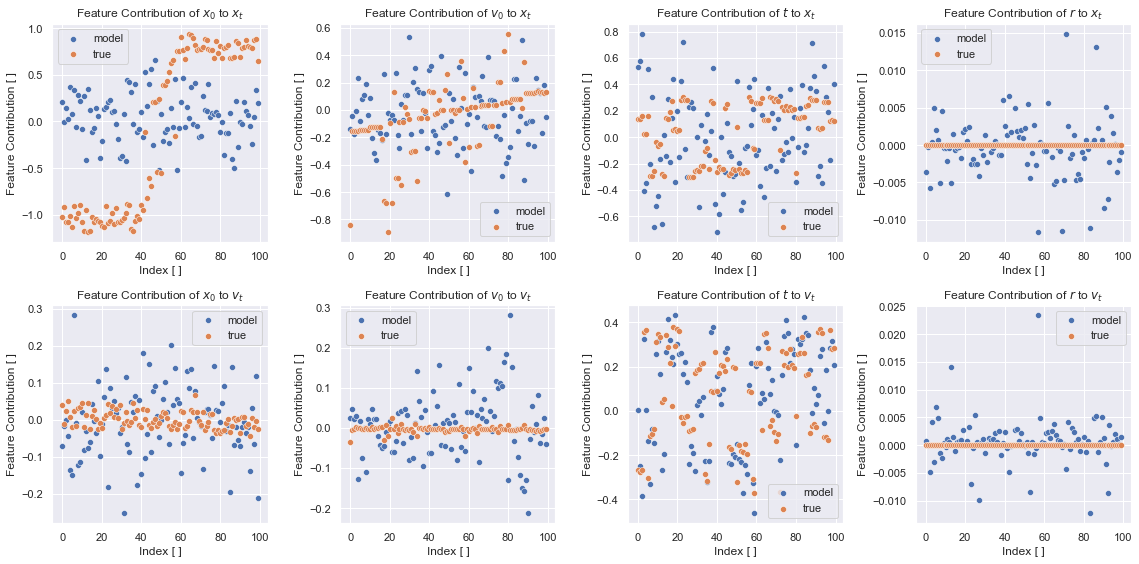

In [95]:
f, axs = plt.subplots(2, 4, figsize=(16, 8), gridspec_kw=dict(width_ratios=[4, 4, 4, 4]))

sns.scatterplot(data = model_plot_data_x0_xt, x = model_plot_data_x0_xt.index,  y='x0', label = 'model', ax=axs[0,0])
sns.scatterplot(data = true_plot_data_x0_xt, x = true_plot_data_x0_xt.index,  y='x0', label='true',ax=axs[0,0])
axs[0,0].set_title(r"Feature Contribution of $x_0$ to $x_t$")
axs[0,0].set_xlabel('Index [ ]')
axs[0,0].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = model_plot_data_v0_xt, x = model_plot_data_v0_xt.index,  y='v0', label = 'model', ax=axs[0,1])
sns.scatterplot(data = true_plot_data_v0_xt, x = true_plot_data_v0_xt.index,  y='v0', label='true',ax=axs[0,1])
axs[0,1].set_title(r"Feature Contribution of $v_0$ to $x_t$")
axs[0,1].set_xlabel('Index [ ]')
axs[0,1].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = model_plot_data_t_xt, x = model_plot_data_t_xt.index,  y='t', label = 'model', ax=axs[0,2])
sns.scatterplot(data = true_plot_data_t_xt, x = true_plot_data_t_xt.index,  y='t', label='true',ax=axs[0,2])
axs[0,2].set_title(r"Feature Contribution of $t$ to $x_t$")
axs[0,2].set_xlabel('Index [ ]')
axs[0,2].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = model_plot_data_x0_vt, x = model_plot_data_x0_vt.index,  y='x0', label = 'model', ax=axs[1,0])
sns.scatterplot(data = true_plot_data_x0_vt, x = true_plot_data_x0_vt.index,  y='x0', label='true',ax=axs[1,0])
axs[1,0].set_title(r"Feature Contribution of $x_0$ to $v_t$")
axs[1,0].set_xlabel('Index [ ]')
axs[1,0].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = model_plot_data_v0_vt, x =model_plot_data_v0_vt.index,  y='v0', label = 'model', ax=axs[1,1])
sns.scatterplot(data = true_plot_data_v0_vt, x = true_plot_data_v0_vt.index,  y='v0', label='true',ax=axs[1,1])
axs[1,1].set_title(r"Feature Contribution of $v_0$ to $v_t$")
axs[1,1].set_xlabel('Index [ ]')
axs[1,1].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = model_plot_data_t_vt, x = model_plot_data_t_vt.index,  y='t', label = 'model', ax=axs[1,2])
sns.scatterplot(data = true_plot_data_t_vt, x = true_plot_data_t_vt.index,  y='t', label='true',ax=axs[1,2])
axs[1,2].set_title(r"Feature Contribution of $t$ to $v_t$")
axs[1,2].set_xlabel('Index [ ]')
axs[1,2].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = model_plot_data_x0_xt, x = model_plot_data_x0_xt.index,  y='rand', label = 'model', ax=axs[0,3])
sns.scatterplot(data = true_plot_data_x0_xt, x = true_plot_data_x0_xt.index,  y='rand', label='true',ax=axs[0,3])
axs[0,3].set_title(r"Feature Contribution of $r$ to $x_t$")
axs[0,3].set_xlabel('Index [ ]')
axs[0,3].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = model_plot_data_x0_vt, x = model_plot_data_x0_vt.index,  y='rand', label = 'model', ax=axs[1,3])
sns.scatterplot(data = true_plot_data_x0_vt, x = true_plot_data_x0_vt.index,  y='rand', label='true',ax=axs[1,3])
axs[1,3].set_title(r"Feature Contribution of $r$ to $v_t$")
axs[1,3].set_xlabel('Index [ ]')
axs[1,3].set_ylabel('Feature Contribution [ ]')

f.tight_layout()

f.savefig("Images/shap_summary"+suffix+"_kernel.svg", dpi='figure')

In [21]:
sorted_true_values_x0 = true_explainer_partition(shap_choice_x0)
sorted_model_values_x0 = explainer_partition(shap_choice_x0)

sorted_true_values_v0 = true_explainer_partition(shap_choice_v0)
sorted_model_values_v0 = explainer_partition(shap_choice_v0)

sorted_true_values_t = true_explainer_partition(shap_choice_t)
sorted_model_values_t = explainer_partition(shap_choice_t)

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   1%|          | 1/179 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   2%|▏         | 3/179 [00:19<11:08,  3.80s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   2%|▏         | 4/179 [00:30<20:38,  7.08s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   3%|▎         | 5/179 [00:42<25:22,  8.75s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   3%|▎         | 6/179 [00:52<26:18,  9.13s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   4%|▍         | 7/179 [01:00<25:07,  8.76s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   4%|▍         | 8/179 [01:09<25:41,  9.01s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   5%|▌         | 9/179 [01:18<25:10,  8.89s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   6%|▌         | 10/179 [01:28<26:06,  9.27s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   6%|▌         | 11/179 [01:37<25:21,  9.06s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   7%|▋         | 12/179 [01:49<27:47,  9.99s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   7%|▋         | 13/179 [02:02<30:31, 11.03s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   8%|▊         | 14/179 [02:13<30:04, 10.94s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   8%|▊         | 15/179 [02:20<26:16,  9.61s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   9%|▉         | 16/179 [02:26<23:49,  8.77s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   9%|▉         | 17/179 [02:38<26:10,  9.70s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  10%|█         | 18/179 [02:52<29:21, 10.94s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  11%|█         | 19/179 [03:06<31:55, 11.97s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  11%|█         | 20/179 [03:15<29:02, 10.96s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  12%|█▏        | 21/179 [03:30<32:18, 12.27s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  12%|█▏        | 22/179 [03:43<32:05, 12.27s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  13%|█▎        | 23/179 [03:49<27:18, 10.50s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  13%|█▎        | 24/179 [03:55<23:54,  9.25s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  14%|█▍        | 25/179 [04:04<22:57,  8.95s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  15%|█▍        | 26/179 [04:16<25:30, 10.00s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  15%|█▌        | 27/179 [04:26<25:13,  9.96s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  16%|█▌        | 28/179 [04:32<22:08,  8.80s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  16%|█▌        | 29/179 [04:42<22:41,  9.07s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  17%|█▋        | 30/179 [04:57<27:14, 10.97s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  17%|█▋        | 31/179 [05:05<24:30,  9.93s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  18%|█▊        | 32/179 [05:19<27:38, 11.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  18%|█▊        | 33/179 [05:34<30:28, 12.53s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  19%|█▉        | 34/179 [05:47<30:17, 12.54s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  20%|█▉        | 35/179 [05:53<25:34, 10.66s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  20%|██        | 36/179 [06:07<27:15, 11.43s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  21%|██        | 37/179 [06:16<25:54, 10.94s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  21%|██        | 38/179 [06:30<27:46, 11.82s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 39/179 [06:40<26:21, 11.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 40/179 [06:47<22:57,  9.91s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  23%|██▎       | 41/179 [06:58<23:38, 10.28s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  23%|██▎       | 42/179 [07:06<21:50,  9.57s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  24%|██▍       | 43/179 [07:17<22:33,  9.95s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  25%|██▍       | 44/179 [07:26<21:30,  9.56s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 45/179 [07:40<24:19, 10.89s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  26%|██▌       | 46/179 [07:47<22:02,  9.94s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  26%|██▋       | 47/179 [07:55<20:08,  9.15s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  27%|██▋       | 48/179 [08:05<20:50,  9.55s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  27%|██▋       | 49/179 [08:11<18:30,  8.54s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  28%|██▊       | 50/179 [08:20<18:47,  8.74s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  28%|██▊       | 51/179 [08:29<18:42,  8.77s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  29%|██▉       | 52/179 [08:39<19:05,  9.02s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  30%|██▉       | 53/179 [08:53<22:12, 10.57s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  30%|███       | 54/179 [09:05<23:06, 11.10s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  31%|███       | 55/179 [09:16<22:33, 10.91s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  31%|███▏      | 56/179 [09:29<23:30, 11.46s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  32%|███▏      | 57/179 [09:38<21:46, 10.71s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  32%|███▏      | 58/179 [09:46<20:19, 10.08s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 59/179 [09:53<18:18,  9.15s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  34%|███▎      | 60/179 [10:01<17:22,  8.76s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  34%|███▍      | 61/179 [10:13<19:06,  9.72s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  35%|███▍      | 62/179 [10:23<19:10,  9.83s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  35%|███▌      | 63/179 [10:36<20:38, 10.68s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  36%|███▌      | 64/179 [10:48<21:21, 11.14s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  36%|███▋      | 65/179 [10:58<20:26, 10.76s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  37%|███▋      | 66/179 [11:06<18:39,  9.91s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  37%|███▋      | 67/179 [11:14<17:35,  9.42s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  38%|███▊      | 68/179 [11:22<16:38,  9.00s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  39%|███▊      | 69/179 [11:28<14:53,  8.13s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  39%|███▉      | 70/179 [11:34<13:39,  7.52s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  40%|███▉      | 71/179 [11:46<16:02,  8.91s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  40%|████      | 72/179 [11:58<17:19,  9.72s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  41%|████      | 73/179 [12:06<16:16,  9.21s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  41%|████▏     | 74/179 [12:18<17:48, 10.18s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  42%|████▏     | 75/179 [12:29<17:35, 10.15s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  42%|████▏     | 76/179 [12:37<16:22,  9.54s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  43%|████▎     | 77/179 [12:50<18:00, 10.59s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  44%|████▎     | 78/179 [13:02<18:47, 11.17s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  44%|████▍     | 79/179 [13:14<18:58, 11.38s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  45%|████▍     | 80/179 [13:27<19:19, 11.71s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  45%|████▌     | 81/179 [13:39<19:32, 11.96s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  46%|████▌     | 82/179 [13:49<18:11, 11.25s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  46%|████▋     | 83/179 [13:55<15:44,  9.84s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  47%|████▋     | 84/179 [14:03<14:46,  9.33s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  47%|████▋     | 85/179 [14:17<16:27, 10.51s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  48%|████▊     | 86/179 [14:26<15:51, 10.23s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  49%|████▊     | 87/179 [14:40<17:13, 11.24s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  49%|████▉     | 88/179 [14:48<15:39, 10.33s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  50%|████▉     | 89/179 [14:54<13:36,  9.07s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 90/179 [15:05<14:17,  9.63s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  51%|█████     | 91/179 [15:14<13:59,  9.54s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  51%|█████▏    | 92/179 [15:28<15:35, 10.75s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  52%|█████▏    | 93/179 [15:35<13:50,  9.65s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  53%|█████▎    | 94/179 [15:49<15:41, 11.08s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  53%|█████▎    | 95/179 [15:58<14:18, 10.22s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  54%|█████▎    | 96/179 [16:11<15:21, 11.10s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  54%|█████▍    | 97/179 [16:26<16:53, 12.36s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  55%|█████▍    | 98/179 [16:39<16:59, 12.58s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  55%|█████▌    | 99/179 [16:51<16:30, 12.38s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  56%|█████▌    | 100/179 [17:00<15:03, 11.44s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  56%|█████▋    | 101/179 [17:12<15:05, 11.61s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  57%|█████▋    | 102/179 [17:24<15:00, 11.70s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  58%|█████▊    | 103/179 [17:36<14:56, 11.79s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  58%|█████▊    | 104/179 [17:44<13:18, 10.65s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  59%|█████▊    | 105/179 [17:54<12:52, 10.44s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  59%|█████▉    | 106/179 [18:04<12:24, 10.20s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  60%|█████▉    | 107/179 [18:13<11:43,  9.78s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 108/179 [18:22<11:14,  9.50s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  61%|██████    | 109/179 [18:36<12:53, 11.05s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  61%|██████▏   | 110/179 [18:48<12:51, 11.18s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  62%|██████▏   | 111/179 [18:59<12:34, 11.10s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  63%|██████▎   | 112/179 [19:06<11:17, 10.11s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  63%|██████▎   | 113/179 [19:14<10:23,  9.45s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  64%|██████▎   | 114/179 [19:24<10:11,  9.40s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  64%|██████▍   | 115/179 [19:33<10:10,  9.53s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  65%|██████▍   | 116/179 [19:43<10:06,  9.63s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  65%|██████▌   | 117/179 [19:55<10:27, 10.12s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  66%|██████▌   | 118/179 [20:05<10:20, 10.17s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  66%|██████▋   | 119/179 [20:20<11:32, 11.54s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  67%|██████▋   | 120/179 [20:33<12:01, 12.23s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  68%|██████▊   | 121/179 [20:43<11:06, 11.49s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  68%|██████▊   | 122/179 [20:50<09:41, 10.20s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  69%|██████▊   | 123/179 [21:01<09:46, 10.47s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  69%|██████▉   | 124/179 [21:14<10:16, 11.21s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  70%|██████▉   | 125/179 [21:26<10:08, 11.26s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  70%|███████   | 126/179 [21:33<08:46,  9.93s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  71%|███████   | 127/179 [21:44<08:53, 10.26s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  72%|███████▏  | 128/179 [21:53<08:34, 10.08s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  72%|███████▏  | 129/179 [22:06<09:06, 10.92s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  73%|███████▎  | 130/179 [22:14<08:15, 10.12s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  73%|███████▎  | 131/179 [22:22<07:29,  9.37s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  74%|███████▎  | 132/179 [22:29<06:40,  8.52s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  74%|███████▍  | 133/179 [22:35<06:01,  7.85s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  75%|███████▍  | 134/179 [22:48<07:04,  9.44s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 135/179 [22:57<06:44,  9.20s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  76%|███████▌  | 136/179 [23:09<07:09,  9.99s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  77%|███████▋  | 137/179 [23:21<07:35, 10.84s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  77%|███████▋  | 138/179 [23:28<06:35,  9.65s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  78%|███████▊  | 139/179 [23:41<07:06, 10.66s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  78%|███████▊  | 140/179 [23:55<07:36, 11.70s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  79%|███████▉  | 141/179 [24:06<07:09, 11.31s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  79%|███████▉  | 142/179 [24:19<07:24, 12.00s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  80%|███████▉  | 143/179 [24:28<06:31, 10.87s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 144/179 [24:34<05:35,  9.60s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  81%|████████  | 145/179 [24:45<05:37,  9.91s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  82%|████████▏ | 146/179 [24:54<05:14,  9.54s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  82%|████████▏ | 147/179 [25:00<04:38,  8.70s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  83%|████████▎ | 148/179 [25:15<05:21, 10.38s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  83%|████████▎ | 149/179 [25:30<05:56, 11.89s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  84%|████████▍ | 150/179 [25:38<05:14, 10.83s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  84%|████████▍ | 151/179 [25:47<04:44, 10.17s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  85%|████████▍ | 152/179 [26:02<05:15, 11.67s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  85%|████████▌ | 153/179 [26:08<04:18,  9.96s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  86%|████████▌ | 154/179 [26:20<04:23, 10.52s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  87%|████████▋ | 155/179 [26:33<04:27, 11.14s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  87%|████████▋ | 156/179 [26:45<04:28, 11.68s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  88%|████████▊ | 157/179 [26:59<04:28, 12.23s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  88%|████████▊ | 158/179 [27:09<04:02, 11.57s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  89%|████████▉ | 159/179 [27:24<04:10, 12.55s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  89%|████████▉ | 160/179 [27:33<03:39, 11.53s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  90%|████████▉ | 161/179 [27:43<03:19, 11.08s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  91%|█████████ | 162/179 [27:51<02:54, 10.28s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  91%|█████████ | 163/179 [28:02<02:43, 10.23s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  92%|█████████▏| 164/179 [28:17<02:56, 11.78s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  92%|█████████▏| 165/179 [28:25<02:29, 10.68s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  93%|█████████▎| 166/179 [28:36<02:20, 10.80s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  93%|█████████▎| 167/179 [28:44<02:00, 10.03s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  94%|█████████▍| 168/179 [28:53<01:44,  9.48s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  94%|█████████▍| 169/179 [29:02<01:34,  9.50s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  95%|█████████▍| 170/179 [29:09<01:18,  8.70s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  96%|█████████▌| 171/179 [29:15<01:03,  7.96s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  96%|█████████▌| 172/179 [29:24<00:57,  8.16s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  97%|█████████▋| 173/179 [29:34<00:52,  8.68s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  97%|█████████▋| 174/179 [29:47<00:50, 10.02s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  98%|█████████▊| 175/179 [29:58<00:41, 10.46s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  98%|█████████▊| 176/179 [30:06<00:28,  9.57s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  99%|█████████▉| 177/179 [30:12<00:17,  8.56s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  99%|█████████▉| 178/179 [30:21<00:08,  8.81s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 179/179 [30:35<00:00, 10.30s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer: 180it [30:48, 10.33s/it]                         
Partition explainer: 180it [00:32,  3.95it/s]                         


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   1%|          | 2/236 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   2%|▏         | 4/236 [00:35<29:58,  7.75s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   2%|▏         | 5/236 [00:49<39:38, 10.30s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   3%|▎         | 6/236 [01:05<47:21, 12.35s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   3%|▎         | 7/236 [01:14<42:30, 11.14s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   3%|▎         | 8/236 [01:20<35:55,  9.45s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   4%|▍         | 9/236 [01:27<32:53,  8.69s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   4%|▍         | 10/236 [01:34<31:22,  8.33s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   5%|▍         | 11/236 [01:47<36:54,  9.84s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   5%|▌         | 12/236 [02:01<41:35, 11.14s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   6%|▌         | 13/236 [02:10<38:37, 10.39s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   6%|▌         | 14/236 [02:19<37:08, 10.04s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   6%|▋         | 15/236 [02:29<35:58,  9.77s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   7%|▋         | 16/236 [02:42<40:20, 11.00s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   7%|▋         | 17/236 [02:50<36:41, 10.05s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   8%|▊         | 18/236 [02:57<32:51,  9.04s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   8%|▊         | 19/236 [03:04<30:42,  8.49s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   8%|▊         | 20/236 [03:12<30:07,  8.37s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   9%|▉         | 21/236 [03:27<36:38, 10.23s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   9%|▉         | 22/236 [03:40<39:51, 11.17s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  10%|▉         | 23/236 [03:51<39:48, 11.21s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  10%|█         | 24/236 [04:07<44:02, 12.47s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  11%|█         | 25/236 [04:16<40:06, 11.40s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  11%|█         | 26/236 [04:29<41:21, 11.82s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  11%|█▏        | 27/236 [04:40<40:58, 11.76s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  12%|█▏        | 28/236 [04:50<38:49, 11.20s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  12%|█▏        | 29/236 [05:02<39:49, 11.54s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  13%|█▎        | 30/236 [05:17<42:45, 12.45s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  13%|█▎        | 31/236 [05:27<40:27, 11.84s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  14%|█▎        | 32/236 [05:36<37:15, 10.96s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  14%|█▍        | 33/236 [05:51<40:27, 11.96s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  14%|█▍        | 34/236 [06:03<40:24, 12.00s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  15%|█▍        | 35/236 [06:09<34:25, 10.28s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  15%|█▌        | 36/236 [06:21<35:35, 10.68s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  16%|█▌        | 37/236 [06:27<31:38,  9.54s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  16%|█▌        | 38/236 [06:42<36:30, 11.06s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  17%|█▋        | 39/236 [06:51<34:00, 10.36s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  17%|█▋        | 40/236 [07:01<33:45, 10.33s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  17%|█▋        | 41/236 [07:09<31:07,  9.58s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  18%|█▊        | 42/236 [07:21<33:08, 10.25s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  18%|█▊        | 43/236 [07:34<35:36, 11.07s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  19%|█▊        | 44/236 [07:43<33:50, 10.58s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  19%|█▉        | 45/236 [07:56<35:42, 11.22s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  19%|█▉        | 46/236 [08:05<33:13, 10.49s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  20%|█▉        | 47/236 [08:16<33:39, 10.68s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  20%|██        | 48/236 [08:22<29:17,  9.35s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  21%|██        | 49/236 [08:37<34:07, 10.95s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  21%|██        | 50/236 [08:47<33:00, 10.65s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 51/236 [08:53<29:18,  9.51s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 52/236 [09:00<26:01,  8.49s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 53/236 [09:15<32:11, 10.56s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  23%|██▎       | 54/236 [09:22<28:22,  9.35s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  23%|██▎       | 55/236 [09:34<31:28, 10.43s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  24%|██▎       | 56/236 [09:49<35:25, 11.81s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  24%|██▍       | 57/236 [10:02<35:29, 11.89s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  25%|██▍       | 58/236 [10:13<35:09, 11.85s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 59/236 [10:20<30:17, 10.27s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 60/236 [10:30<29:53, 10.19s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  26%|██▌       | 61/236 [10:45<34:03, 11.68s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  26%|██▋       | 62/236 [10:57<34:29, 11.89s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  27%|██▋       | 63/236 [11:08<32:47, 11.37s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  27%|██▋       | 64/236 [11:15<29:12, 10.19s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  28%|██▊       | 65/236 [11:30<33:14, 11.67s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  28%|██▊       | 66/236 [11:43<34:24, 12.14s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  28%|██▊       | 67/236 [11:56<34:18, 12.18s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  29%|██▉       | 68/236 [12:07<33:18, 11.89s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  29%|██▉       | 69/236 [12:21<34:46, 12.49s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  30%|██▉       | 70/236 [12:30<32:08, 11.62s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  30%|███       | 71/236 [12:44<33:20, 12.12s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  31%|███       | 72/236 [12:58<34:36, 12.66s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  31%|███       | 73/236 [13:05<29:53, 11.01s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  31%|███▏      | 74/236 [13:16<29:48, 11.04s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  32%|███▏      | 75/236 [13:24<27:26, 10.23s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  32%|███▏      | 76/236 [13:38<30:16, 11.35s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 77/236 [13:44<25:49,  9.75s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 78/236 [13:55<26:21, 10.01s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 79/236 [14:09<29:46, 11.38s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  34%|███▍      | 80/236 [14:16<26:10, 10.07s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  34%|███▍      | 81/236 [14:24<24:03,  9.31s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  35%|███▍      | 82/236 [14:39<28:42, 11.18s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  35%|███▌      | 83/236 [14:46<24:53,  9.76s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  36%|███▌      | 84/236 [14:58<26:43, 10.55s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  36%|███▌      | 85/236 [15:10<27:20, 10.87s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  36%|███▋      | 86/236 [15:23<28:42, 11.48s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  37%|███▋      | 87/236 [15:29<24:45,  9.97s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  37%|███▋      | 88/236 [15:36<22:25,  9.09s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  38%|███▊      | 89/236 [15:48<24:16,  9.91s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  38%|███▊      | 90/236 [15:58<23:59,  9.86s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  39%|███▊      | 91/236 [16:10<25:18, 10.47s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  39%|███▉      | 92/236 [16:20<25:18, 10.55s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  39%|███▉      | 93/236 [16:31<25:08, 10.55s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  40%|███▉      | 94/236 [16:46<28:07, 11.89s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  40%|████      | 95/236 [16:52<24:03, 10.24s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  41%|████      | 96/236 [17:06<25:56, 11.12s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  41%|████      | 97/236 [17:19<27:31, 11.88s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  42%|████▏     | 98/236 [17:30<26:12, 11.39s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  42%|████▏     | 99/236 [17:41<26:03, 11.42s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  42%|████▏     | 100/236 [17:54<26:58, 11.90s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  43%|████▎     | 101/236 [18:07<27:19, 12.15s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  43%|████▎     | 102/236 [18:22<29:17, 13.12s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  44%|████▎     | 103/236 [18:35<28:41, 12.95s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  44%|████▍     | 104/236 [18:43<25:43, 11.69s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  44%|████▍     | 105/236 [18:53<24:18, 11.13s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  45%|████▍     | 106/236 [19:05<24:23, 11.26s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  45%|████▌     | 107/236 [19:17<24:48, 11.54s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  46%|████▌     | 108/236 [19:31<25:59, 12.18s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  46%|████▌     | 109/236 [19:37<21:51, 10.32s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  47%|████▋     | 110/236 [19:45<20:25,  9.72s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  47%|████▋     | 111/236 [19:57<21:32, 10.34s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  47%|████▋     | 112/236 [20:12<24:34, 11.89s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  48%|████▊     | 113/236 [20:27<26:24, 12.88s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  48%|████▊     | 114/236 [20:35<22:56, 11.28s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  49%|████▊     | 115/236 [20:50<24:53, 12.34s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  49%|████▉     | 116/236 [21:02<24:49, 12.41s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  50%|████▉     | 117/236 [21:15<24:59, 12.60s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 118/236 [21:23<21:31, 10.94s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 119/236 [21:33<21:18, 10.93s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  51%|█████     | 120/236 [21:45<21:20, 11.04s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  51%|█████▏    | 121/236 [21:52<19:11, 10.01s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  52%|█████▏    | 122/236 [22:05<20:25, 10.75s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  52%|█████▏    | 123/236 [22:12<18:15,  9.70s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  53%|█████▎    | 124/236 [22:26<20:38, 11.06s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  53%|█████▎    | 125/236 [22:38<20:34, 11.12s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  53%|█████▎    | 126/236 [22:46<19:00, 10.36s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  54%|█████▍    | 127/236 [22:59<19:54, 10.96s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  54%|█████▍    | 128/236 [23:09<19:42, 10.95s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  55%|█████▍    | 129/236 [23:22<20:13, 11.34s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  55%|█████▌    | 130/236 [23:37<22:07, 12.52s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  56%|█████▌    | 131/236 [23:45<19:21, 11.07s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  56%|█████▌    | 132/236 [23:56<19:12, 11.08s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  56%|█████▋    | 133/236 [24:06<18:33, 10.81s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  57%|█████▋    | 134/236 [24:20<19:59, 11.75s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  57%|█████▋    | 135/236 [24:32<19:59, 11.88s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  58%|█████▊    | 136/236 [24:45<20:18, 12.19s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  58%|█████▊    | 137/236 [24:56<19:31, 11.84s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  58%|█████▊    | 138/236 [25:11<21:02, 12.88s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  59%|█████▉    | 139/236 [25:24<20:38, 12.77s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  59%|█████▉    | 140/236 [25:37<20:36, 12.88s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  60%|█████▉    | 141/236 [25:46<18:32, 11.71s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 142/236 [25:56<17:30, 11.17s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  61%|██████    | 143/236 [26:06<17:04, 11.01s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  61%|██████    | 144/236 [26:18<17:04, 11.13s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  61%|██████▏   | 145/236 [26:31<17:53, 11.79s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  62%|██████▏   | 146/236 [26:47<19:16, 12.85s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  62%|██████▏   | 147/236 [26:59<18:53, 12.73s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  63%|██████▎   | 148/236 [27:12<18:50, 12.85s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  63%|██████▎   | 149/236 [27:23<17:39, 12.18s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  64%|██████▎   | 150/236 [27:36<17:45, 12.39s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  64%|██████▍   | 151/236 [27:43<15:17, 10.80s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  64%|██████▍   | 152/236 [27:58<17:01, 12.17s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  65%|██████▍   | 153/236 [28:12<17:24, 12.58s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  65%|██████▌   | 154/236 [28:26<17:55, 13.12s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  66%|██████▌   | 155/236 [28:37<16:52, 12.50s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  66%|██████▌   | 156/236 [28:47<15:50, 11.89s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  67%|██████▋   | 157/236 [29:01<16:09, 12.27s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  67%|██████▋   | 158/236 [29:09<14:25, 11.09s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  67%|██████▋   | 159/236 [29:24<15:44, 12.27s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  68%|██████▊   | 160/236 [29:38<16:06, 12.71s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  68%|██████▊   | 161/236 [29:46<14:09, 11.33s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  69%|██████▊   | 162/236 [29:57<14:04, 11.41s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  69%|██████▉   | 163/236 [30:10<14:26, 11.87s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  69%|██████▉   | 164/236 [30:20<13:16, 11.06s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  70%|██████▉   | 165/236 [30:26<11:26,  9.67s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  70%|███████   | 166/236 [30:37<11:49, 10.13s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  71%|███████   | 167/236 [30:47<11:30, 10.01s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  71%|███████   | 168/236 [30:58<11:36, 10.24s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  72%|███████▏  | 169/236 [31:07<10:59,  9.84s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  72%|███████▏  | 170/236 [31:20<11:59, 10.90s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  72%|███████▏  | 171/236 [31:34<12:54, 11.91s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  73%|███████▎  | 172/236 [31:50<13:49, 12.97s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  73%|███████▎  | 173/236 [32:05<14:25, 13.74s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  74%|███████▎  | 174/236 [32:13<12:17, 11.90s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  74%|███████▍  | 175/236 [32:20<10:43, 10.55s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  75%|███████▍  | 176/236 [32:28<09:42,  9.70s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 177/236 [32:34<08:34,  8.71s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 178/236 [32:48<09:57, 10.30s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  76%|███████▌  | 179/236 [33:00<10:12, 10.75s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  76%|███████▋  | 180/236 [33:12<10:21, 11.09s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  77%|███████▋  | 181/236 [33:27<11:16, 12.30s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  77%|███████▋  | 182/236 [33:38<10:32, 11.71s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  78%|███████▊  | 183/236 [33:48<10:06, 11.45s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  78%|███████▊  | 184/236 [33:54<08:32,  9.85s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  78%|███████▊  | 185/236 [34:01<07:27,  8.78s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  79%|███████▉  | 186/236 [34:12<07:56,  9.53s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  79%|███████▉  | 187/236 [34:28<09:14, 11.33s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  80%|███████▉  | 188/236 [34:39<09:00, 11.26s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 189/236 [34:48<08:22, 10.69s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  81%|████████  | 190/236 [35:03<09:16, 12.11s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  81%|████████  | 191/236 [35:11<08:01, 10.71s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  81%|████████▏ | 192/236 [35:21<07:38, 10.41s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  82%|████████▏ | 193/236 [35:29<07:03,  9.86s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  82%|████████▏ | 194/236 [35:38<06:41,  9.56s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  83%|████████▎ | 195/236 [35:45<06:03,  8.86s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  83%|████████▎ | 196/236 [36:01<07:13, 10.84s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  83%|████████▎ | 197/236 [36:10<06:47, 10.44s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  84%|████████▍ | 198/236 [36:20<06:30, 10.28s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  84%|████████▍ | 199/236 [36:28<05:54,  9.59s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  85%|████████▍ | 200/236 [36:35<05:14,  8.74s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  85%|████████▌ | 201/236 [36:49<06:03, 10.40s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  86%|████████▌ | 202/236 [37:04<06:36, 11.67s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  86%|████████▌ | 203/236 [37:10<05:29, 10.00s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  86%|████████▋ | 204/236 [37:24<06:04, 11.38s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  87%|████████▋ | 205/236 [37:39<06:17, 12.19s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  87%|████████▋ | 206/236 [37:51<06:08, 12.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  88%|████████▊ | 207/236 [38:01<05:36, 11.59s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  88%|████████▊ | 208/236 [38:12<05:20, 11.44s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  89%|████████▊ | 209/236 [38:20<04:42, 10.47s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  89%|████████▉ | 210/236 [38:34<04:58, 11.49s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  89%|████████▉ | 211/236 [38:49<05:11, 12.48s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  90%|████████▉ | 212/236 [38:57<04:26, 11.11s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  90%|█████████ | 213/236 [39:05<03:56, 10.28s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  91%|█████████ | 214/236 [39:13<03:28,  9.46s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  91%|█████████ | 215/236 [39:21<03:08,  8.98s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  92%|█████████▏| 216/236 [39:28<02:47,  8.37s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  92%|█████████▏| 217/236 [39:36<02:37,  8.27s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  92%|█████████▏| 218/236 [39:43<02:25,  8.10s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  93%|█████████▎| 219/236 [39:58<02:49,  9.99s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  93%|█████████▎| 220/236 [40:06<02:29,  9.37s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  94%|█████████▎| 221/236 [40:15<02:21,  9.45s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  94%|█████████▍| 222/236 [40:30<02:35, 11.07s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  94%|█████████▍| 223/236 [40:45<02:37, 12.10s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  95%|█████████▍| 224/236 [40:57<02:24, 12.05s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  95%|█████████▌| 225/236 [41:03<01:52, 10.22s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  96%|█████████▌| 226/236 [41:14<01:45, 10.56s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  96%|█████████▌| 227/236 [41:20<01:23,  9.32s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  97%|█████████▋| 228/236 [41:34<01:24, 10.53s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  97%|█████████▋| 229/236 [41:40<01:05,  9.38s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  97%|█████████▋| 230/236 [41:53<01:01, 10.30s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  98%|█████████▊| 231/236 [42:03<00:50, 10.17s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  98%|█████████▊| 232/236 [42:13<00:40, 10.06s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  99%|█████████▊| 233/236 [42:19<00:27,  9.01s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  99%|█████████▉| 234/236 [42:31<00:20, 10.02s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer: 100%|█████████▉| 235/236 [42:39<00:09,  9.25s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 236/236 [42:50<00:00,  9.83s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer: 237it [42:58, 10.97s/it]                         
Partition explainer: 237it [00:41,  4.30it/s]                         


  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   0%|          | 2/521 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   1%|          | 4/521 [00:17<25:25,  2.95s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   1%|          | 5/521 [00:23<35:50,  4.17s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   1%|          | 6/521 [00:29<41:29,  4.83s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   1%|▏         | 7/521 [00:35<44:33,  5.20s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   2%|▏         | 8/521 [00:41<46:35,  5.45s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   2%|▏         | 9/521 [00:47<47:47,  5.60s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   2%|▏         | 10/521 [00:53<49:13,  5.78s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   2%|▏         | 11/521 [00:59<49:41,  5.85s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   2%|▏         | 12/521 [01:05<50:01,  5.90s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   2%|▏         | 13/521 [01:11<50:34,  5.97s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   3%|▎         | 14/521 [01:17<50:42,  6.00s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   3%|▎         | 15/521 [01:23<50:34,  6.00s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   3%|▎         | 16/521 [01:29<50:43,  6.03s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   3%|▎         | 17/521 [01:35<51:17,  6.11s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   3%|▎         | 18/521 [01:42<51:16,  6.12s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   4%|▎         | 19/521 [01:48<51:41,  6.18s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   4%|▍         | 20/521 [01:54<52:05,  6.24s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   4%|▍         | 21/521 [02:01<51:56,  6.23s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   4%|▍         | 22/521 [02:07<51:49,  6.23s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   4%|▍         | 23/521 [02:13<51:50,  6.25s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   5%|▍         | 24/521 [02:19<51:51,  6.26s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   5%|▍         | 25/521 [02:26<51:43,  6.26s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   5%|▍         | 26/521 [02:32<51:54,  6.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   5%|▌         | 27/521 [02:38<52:06,  6.33s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   5%|▌         | 28/521 [02:45<51:50,  6.31s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   6%|▌         | 29/521 [02:51<51:37,  6.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   6%|▌         | 30/521 [02:57<51:32,  6.30s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   6%|▌         | 31/521 [03:03<51:26,  6.30s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   6%|▌         | 32/521 [03:10<51:34,  6.33s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   6%|▋         | 33/521 [03:16<51:55,  6.38s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   7%|▋         | 34/521 [03:23<51:30,  6.35s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   7%|▋         | 35/521 [03:29<51:21,  6.34s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   7%|▋         | 36/521 [03:36<51:45,  6.40s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   7%|▋         | 37/521 [03:42<51:37,  6.40s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   7%|▋         | 38/521 [03:48<51:31,  6.40s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   7%|▋         | 39/521 [03:55<51:39,  6.43s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   8%|▊         | 40/521 [04:01<51:37,  6.44s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   8%|▊         | 41/521 [04:08<51:48,  6.48s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   8%|▊         | 42/521 [04:15<52:09,  6.53s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   8%|▊         | 43/521 [04:21<52:12,  6.55s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   8%|▊         | 44/521 [04:28<52:14,  6.57s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   9%|▊         | 45/521 [04:34<52:33,  6.62s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   9%|▉         | 46/521 [04:41<52:24,  6.62s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   9%|▉         | 47/521 [04:48<52:35,  6.66s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   9%|▉         | 48/521 [04:54<52:25,  6.65s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:   9%|▉         | 49/521 [05:01<52:13,  6.64s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  10%|▉         | 50/521 [05:08<52:08,  6.64s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  10%|▉         | 51/521 [05:14<52:02,  6.64s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  10%|▉         | 52/521 [05:21<51:43,  6.62s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  10%|█         | 53/521 [05:27<51:22,  6.59s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  10%|█         | 54/521 [05:34<51:16,  6.59s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  11%|█         | 55/521 [05:41<51:26,  6.62s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  11%|█         | 56/521 [05:47<51:38,  6.66s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  11%|█         | 57/521 [05:54<52:08,  6.74s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  11%|█         | 58/521 [06:01<52:36,  6.82s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  11%|█▏        | 59/521 [06:08<52:44,  6.85s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  12%|█▏        | 60/521 [06:15<52:43,  6.86s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  12%|█▏        | 61/521 [06:22<52:33,  6.86s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  12%|█▏        | 62/521 [06:29<52:25,  6.85s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  12%|█▏        | 63/521 [06:36<52:43,  6.91s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  12%|█▏        | 64/521 [06:43<52:34,  6.90s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  12%|█▏        | 65/521 [06:50<53:00,  6.97s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  13%|█▎        | 66/521 [06:57<53:00,  6.99s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  13%|█▎        | 67/521 [07:04<53:09,  7.02s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  13%|█▎        | 68/521 [07:11<53:39,  7.11s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  13%|█▎        | 69/521 [07:19<53:42,  7.13s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  13%|█▎        | 70/521 [07:26<53:35,  7.13s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  14%|█▎        | 71/521 [07:33<53:30,  7.13s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  14%|█▍        | 72/521 [07:40<53:34,  7.16s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  14%|█▍        | 73/521 [07:47<53:42,  7.19s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  14%|█▍        | 74/521 [07:55<53:39,  7.20s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  14%|█▍        | 75/521 [08:02<53:36,  7.21s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  15%|█▍        | 76/521 [08:09<53:43,  7.24s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  15%|█▍        | 77/521 [08:17<53:55,  7.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  15%|█▍        | 78/521 [08:24<53:47,  7.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  15%|█▌        | 79/521 [08:31<53:58,  7.33s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  15%|█▌        | 80/521 [08:38<53:32,  7.28s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  16%|█▌        | 81/521 [08:46<53:32,  7.30s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  16%|█▌        | 82/521 [08:53<53:49,  7.36s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  16%|█▌        | 83/521 [09:01<53:54,  7.39s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  16%|█▌        | 84/521 [09:08<53:44,  7.38s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  16%|█▋        | 85/521 [09:15<53:39,  7.39s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  17%|█▋        | 86/521 [09:23<53:44,  7.41s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  17%|█▋        | 87/521 [09:31<54:01,  7.47s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  17%|█▋        | 88/521 [09:38<54:01,  7.49s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  17%|█▋        | 89/521 [09:46<54:20,  7.55s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  17%|█▋        | 90/521 [09:53<54:04,  7.53s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  17%|█▋        | 91/521 [10:01<53:57,  7.53s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  18%|█▊        | 92/521 [10:08<53:32,  7.49s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  18%|█▊        | 93/521 [10:16<53:24,  7.49s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  18%|█▊        | 94/521 [10:23<53:24,  7.50s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  18%|█▊        | 95/521 [10:31<53:35,  7.55s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  18%|█▊        | 96/521 [10:38<53:26,  7.55s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  19%|█▊        | 97/521 [10:46<53:13,  7.53s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  19%|█▉        | 98/521 [10:53<53:09,  7.54s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  19%|█▉        | 99/521 [11:01<53:05,  7.55s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  19%|█▉        | 100/521 [11:09<53:04,  7.56s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  19%|█▉        | 101/521 [11:16<53:20,  7.62s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  20%|█▉        | 102/521 [11:24<53:19,  7.64s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  20%|█▉        | 103/521 [11:32<53:02,  7.61s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  20%|█▉        | 104/521 [11:39<52:54,  7.61s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  20%|██        | 105/521 [11:47<53:41,  7.74s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  20%|██        | 106/521 [11:55<53:55,  7.80s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  21%|██        | 107/521 [12:03<54:37,  7.92s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  21%|██        | 108/521 [12:11<54:32,  7.92s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  21%|██        | 109/521 [12:19<54:20,  7.91s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  21%|██        | 110/521 [12:27<54:29,  7.96s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  21%|██▏       | 111/521 [12:35<54:09,  7.93s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  21%|██▏       | 112/521 [12:43<53:46,  7.89s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 113/521 [12:51<53:48,  7.91s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 114/521 [12:59<53:51,  7.94s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 115/521 [13:07<54:24,  8.04s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 116/521 [13:15<54:21,  8.05s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  22%|██▏       | 117/521 [13:23<54:04,  8.03s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  23%|██▎       | 118/521 [13:31<53:46,  8.01s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  23%|██▎       | 119/521 [13:39<53:59,  8.06s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  23%|██▎       | 120/521 [13:47<53:58,  8.08s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  23%|██▎       | 121/521 [13:56<53:47,  8.07s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  23%|██▎       | 122/521 [14:04<53:37,  8.06s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  24%|██▎       | 123/521 [14:12<53:45,  8.10s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  24%|██▍       | 124/521 [14:20<54:11,  8.19s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  24%|██▍       | 125/521 [14:29<54:21,  8.24s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  24%|██▍       | 126/521 [14:37<54:29,  8.28s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  24%|██▍       | 127/521 [14:45<54:33,  8.31s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  25%|██▍       | 128/521 [14:54<54:37,  8.34s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  25%|██▍       | 129/521 [15:02<54:10,  8.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  25%|██▍       | 130/521 [15:10<53:54,  8.27s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 131/521 [15:18<53:43,  8.27s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  25%|██▌       | 132/521 [15:27<53:45,  8.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  26%|██▌       | 133/521 [15:35<53:20,  8.25s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  26%|██▌       | 134/521 [15:43<53:42,  8.33s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  26%|██▌       | 135/521 [15:52<53:42,  8.35s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  26%|██▌       | 136/521 [16:00<53:35,  8.35s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  26%|██▋       | 137/521 [16:08<53:17,  8.33s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  26%|██▋       | 138/521 [16:17<53:27,  8.37s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  27%|██▋       | 139/521 [16:25<53:20,  8.38s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  27%|██▋       | 140/521 [16:34<53:26,  8.42s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  27%|██▋       | 141/521 [16:42<52:58,  8.36s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  27%|██▋       | 142/521 [16:50<52:51,  8.37s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  27%|██▋       | 143/521 [16:59<52:53,  8.39s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  28%|██▊       | 144/521 [17:07<53:05,  8.45s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  28%|██▊       | 145/521 [17:16<52:51,  8.43s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  28%|██▊       | 146/521 [17:24<53:03,  8.49s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  28%|██▊       | 147/521 [17:33<52:52,  8.48s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  28%|██▊       | 148/521 [17:42<52:59,  8.52s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  29%|██▊       | 149/521 [17:50<52:58,  8.54s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  29%|██▉       | 150/521 [17:59<52:46,  8.53s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  29%|██▉       | 151/521 [18:07<53:02,  8.60s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  29%|██▉       | 152/521 [18:16<52:43,  8.57s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  29%|██▉       | 153/521 [18:24<52:29,  8.56s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  30%|██▉       | 154/521 [18:33<52:28,  8.58s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  30%|██▉       | 155/521 [18:42<52:31,  8.61s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  30%|██▉       | 156/521 [18:50<52:39,  8.66s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  30%|███       | 157/521 [18:59<52:46,  8.70s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  30%|███       | 158/521 [19:08<52:37,  8.70s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  31%|███       | 159/521 [19:17<52:30,  8.70s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  31%|███       | 160/521 [19:25<52:28,  8.72s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  31%|███       | 161/521 [19:34<52:22,  8.73s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  31%|███       | 162/521 [19:43<52:31,  8.78s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  31%|███▏      | 163/521 [19:52<52:21,  8.77s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  31%|███▏      | 164/521 [20:01<52:18,  8.79s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  32%|███▏      | 165/521 [20:10<52:17,  8.81s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  32%|███▏      | 166/521 [20:19<52:33,  8.88s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  32%|███▏      | 167/521 [20:27<52:25,  8.88s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  32%|███▏      | 168/521 [20:36<52:27,  8.92s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  32%|███▏      | 169/521 [20:45<52:16,  8.91s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 170/521 [20:55<52:33,  8.99s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 171/521 [21:04<52:33,  9.01s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 172/521 [21:13<52:16,  8.99s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 173/521 [21:21<52:02,  8.97s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  33%|███▎      | 174/521 [21:30<51:56,  8.98s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  34%|███▎      | 175/521 [21:40<52:01,  9.02s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  34%|███▍      | 176/521 [21:49<51:42,  8.99s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  34%|███▍      | 177/521 [21:58<51:38,  9.01s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  34%|███▍      | 178/521 [22:07<51:50,  9.07s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  34%|███▍      | 179/521 [22:16<52:03,  9.13s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  35%|███▍      | 180/521 [22:25<52:13,  9.19s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  35%|███▍      | 181/521 [22:35<52:12,  9.21s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  35%|███▍      | 182/521 [22:44<51:48,  9.17s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  35%|███▌      | 183/521 [22:53<51:38,  9.17s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  35%|███▌      | 184/521 [23:02<51:41,  9.20s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  36%|███▌      | 185/521 [23:12<51:47,  9.25s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  36%|███▌      | 186/521 [23:21<51:45,  9.27s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  36%|███▌      | 187/521 [23:30<51:24,  9.24s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  36%|███▌      | 188/521 [23:39<51:10,  9.22s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  36%|███▋      | 189/521 [23:49<51:14,  9.26s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  36%|███▋      | 190/521 [23:58<51:11,  9.28s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  37%|███▋      | 191/521 [24:07<51:20,  9.34s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  37%|███▋      | 192/521 [24:17<51:19,  9.36s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  37%|███▋      | 193/521 [24:26<50:54,  9.31s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  37%|███▋      | 194/521 [24:35<50:54,  9.34s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  37%|███▋      | 195/521 [24:45<50:35,  9.31s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  38%|███▊      | 196/521 [24:54<50:21,  9.30s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  38%|███▊      | 197/521 [25:03<50:28,  9.35s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  38%|███▊      | 198/521 [25:13<50:23,  9.36s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  38%|███▊      | 199/521 [25:22<50:30,  9.41s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  38%|███▊      | 200/521 [25:32<50:44,  9.48s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  39%|███▊      | 201/521 [25:41<50:38,  9.50s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  39%|███▉      | 202/521 [25:51<50:21,  9.47s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  39%|███▉      | 203/521 [26:00<50:12,  9.47s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  39%|███▉      | 204/521 [26:10<50:20,  9.53s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  39%|███▉      | 205/521 [26:20<50:23,  9.57s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  40%|███▉      | 206/521 [26:29<50:01,  9.53s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  40%|███▉      | 207/521 [26:39<49:48,  9.52s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  40%|███▉      | 208/521 [26:48<49:48,  9.55s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  40%|████      | 209/521 [26:58<49:43,  9.56s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  40%|████      | 210/521 [27:07<49:42,  9.59s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  40%|████      | 211/521 [27:17<49:40,  9.61s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  41%|████      | 212/521 [27:27<49:37,  9.64s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  41%|████      | 213/521 [27:36<49:22,  9.62s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  41%|████      | 214/521 [27:46<49:25,  9.66s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  41%|████▏     | 215/521 [27:56<49:34,  9.72s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  41%|████▏     | 216/521 [28:06<49:40,  9.77s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  42%|████▏     | 217/521 [28:16<49:38,  9.80s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  42%|████▏     | 218/521 [28:26<49:48,  9.86s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  42%|████▏     | 219/521 [28:36<49:47,  9.89s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  42%|████▏     | 220/521 [28:46<49:36,  9.89s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  42%|████▏     | 221/521 [28:56<49:41,  9.94s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  43%|████▎     | 222/521 [29:06<49:43,  9.98s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  43%|████▎     | 223/521 [29:16<49:28,  9.96s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  43%|████▎     | 224/521 [29:26<49:24,  9.98s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  43%|████▎     | 225/521 [29:36<49:11,  9.97s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  43%|████▎     | 226/521 [29:46<49:12, 10.01s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  44%|████▎     | 227/521 [29:56<49:28, 10.10s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  44%|████▍     | 228/521 [30:06<49:17, 10.09s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  44%|████▍     | 229/521 [30:16<49:19, 10.14s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  44%|████▍     | 230/521 [30:27<49:20, 10.17s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  44%|████▍     | 231/521 [30:37<49:06, 10.16s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  45%|████▍     | 232/521 [30:47<49:01, 10.18s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  45%|████▍     | 233/521 [30:57<48:52, 10.18s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  45%|████▍     | 234/521 [31:07<48:50, 10.21s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  45%|████▌     | 235/521 [31:18<48:40, 10.21s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  45%|████▌     | 236/521 [31:28<48:21, 10.18s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  45%|████▌     | 237/521 [31:38<48:19, 10.21s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  46%|████▌     | 238/521 [31:48<48:14, 10.23s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  46%|████▌     | 239/521 [31:59<48:11, 10.25s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  46%|████▌     | 240/521 [32:09<48:07, 10.28s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  46%|████▋     | 241/521 [32:19<48:17, 10.35s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  46%|████▋     | 242/521 [32:30<48:24, 10.41s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  47%|████▋     | 243/521 [32:40<48:12, 10.40s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  47%|████▋     | 244/521 [32:51<48:09, 10.43s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  47%|████▋     | 245/521 [33:01<47:51, 10.40s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  47%|████▋     | 246/521 [33:12<47:48, 10.43s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  47%|████▋     | 247/521 [33:22<47:41, 10.44s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  48%|████▊     | 248/521 [33:33<47:39, 10.47s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  48%|████▊     | 249/521 [33:43<47:41, 10.52s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  48%|████▊     | 250/521 [33:54<47:38, 10.55s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  48%|████▊     | 251/521 [34:05<47:28, 10.55s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  48%|████▊     | 252/521 [34:15<47:21, 10.56s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  49%|████▊     | 253/521 [34:26<47:10, 10.56s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  49%|████▉     | 254/521 [34:36<47:07, 10.59s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  49%|████▉     | 255/521 [34:47<46:57, 10.59s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  49%|████▉     | 256/521 [34:58<47:03, 10.65s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  49%|████▉     | 257/521 [35:08<46:51, 10.65s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  50%|████▉     | 258/521 [35:19<46:42, 10.66s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  50%|████▉     | 259/521 [35:30<46:54, 10.74s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  50%|████▉     | 260/521 [35:41<46:49, 10.76s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 261/521 [35:52<46:36, 10.76s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 262/521 [36:02<46:29, 10.77s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 263/521 [36:13<46:19, 10.77s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  51%|█████     | 264/521 [36:24<46:27, 10.85s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  51%|█████     | 265/521 [36:35<46:21, 10.87s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  51%|█████     | 266/521 [36:46<46:12, 10.87s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  51%|█████     | 267/521 [36:57<46:00, 10.87s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  51%|█████▏    | 268/521 [37:08<45:57, 10.90s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  52%|█████▏    | 269/521 [37:19<45:50, 10.91s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  52%|█████▏    | 270/521 [37:30<45:38, 10.91s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  52%|█████▏    | 271/521 [37:41<45:31, 10.93s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  52%|█████▏    | 272/521 [37:51<45:20, 10.93s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  52%|█████▏    | 273/521 [38:02<45:09, 10.93s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  53%|█████▎    | 274/521 [38:13<45:09, 10.97s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  53%|█████▎    | 275/521 [38:24<44:53, 10.95s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  53%|█████▎    | 276/521 [38:35<44:47, 10.97s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  53%|█████▎    | 277/521 [38:46<44:43, 11.00s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  53%|█████▎    | 278/521 [38:57<44:35, 11.01s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  54%|█████▎    | 279/521 [39:09<44:24, 11.01s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  54%|█████▎    | 280/521 [39:20<44:24, 11.06s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  54%|█████▍    | 281/521 [39:31<44:24, 11.10s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  54%|█████▍    | 282/521 [39:42<44:13, 11.10s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  54%|█████▍    | 283/521 [39:53<44:07, 11.13s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  55%|█████▍    | 284/521 [40:04<43:51, 11.10s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  55%|█████▍    | 285/521 [40:15<43:37, 11.09s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  55%|█████▍    | 286/521 [40:26<43:31, 11.11s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  55%|█████▌    | 287/521 [40:38<43:19, 11.11s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  55%|█████▌    | 288/521 [40:49<43:21, 11.16s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  55%|█████▌    | 289/521 [41:00<43:15, 11.19s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  56%|█████▌    | 290/521 [41:11<42:59, 11.17s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  56%|█████▌    | 291/521 [41:22<42:52, 11.18s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  56%|█████▌    | 292/521 [41:34<42:44, 11.20s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  56%|█████▌    | 293/521 [41:45<42:28, 11.18s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  56%|█████▋    | 294/521 [41:56<42:14, 11.17s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  57%|█████▋    | 295/521 [42:07<42:01, 11.16s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  57%|█████▋    | 296/521 [42:18<42:05, 11.23s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  57%|█████▋    | 297/521 [42:30<41:55, 11.23s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  57%|█████▋    | 298/521 [42:41<41:52, 11.27s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  57%|█████▋    | 299/521 [42:52<41:51, 11.31s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  58%|█████▊    | 300/521 [43:04<41:48, 11.35s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  58%|█████▊    | 301/521 [43:15<41:52, 11.42s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  58%|█████▊    | 302/521 [43:27<41:45, 11.44s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  58%|█████▊    | 303/521 [43:38<41:38, 11.46s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  58%|█████▊    | 304/521 [43:50<41:21, 11.44s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  59%|█████▊    | 305/521 [44:01<41:06, 11.42s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  59%|█████▊    | 306/521 [44:13<40:54, 11.42s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  59%|█████▉    | 307/521 [44:24<40:39, 11.40s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  59%|█████▉    | 308/521 [44:36<40:47, 11.49s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  59%|█████▉    | 309/521 [44:47<40:31, 11.47s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  60%|█████▉    | 310/521 [44:59<40:34, 11.54s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  60%|█████▉    | 311/521 [45:10<40:28, 11.57s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  60%|█████▉    | 312/521 [45:22<40:25, 11.60s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 313/521 [45:34<40:15, 11.61s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 314/521 [45:45<39:55, 11.57s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  60%|██████    | 315/521 [45:57<39:43, 11.57s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  61%|██████    | 316/521 [46:08<39:36, 11.59s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  61%|██████    | 317/521 [46:20<39:31, 11.63s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  61%|██████    | 318/521 [46:32<39:27, 11.66s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  61%|██████    | 319/521 [46:44<39:18, 11.67s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  61%|██████▏   | 320/521 [46:55<39:16, 11.73s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  62%|██████▏   | 321/521 [47:07<39:08, 11.74s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  62%|██████▏   | 322/521 [47:19<38:51, 11.72s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  62%|██████▏   | 323/521 [47:31<38:48, 11.76s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  62%|██████▏   | 324/521 [47:42<38:29, 11.73s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  62%|██████▏   | 325/521 [47:54<38:18, 11.73s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  63%|██████▎   | 326/521 [48:06<38:03, 11.71s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  63%|██████▎   | 327/521 [48:18<37:51, 11.71s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  63%|██████▎   | 328/521 [48:29<37:40, 11.71s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  63%|██████▎   | 329/521 [48:41<37:36, 11.75s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  63%|██████▎   | 330/521 [48:53<37:41, 11.84s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  64%|██████▎   | 331/521 [49:05<37:35, 11.87s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  64%|██████▎   | 332/521 [49:17<37:21, 11.86s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  64%|██████▍   | 333/521 [49:29<37:06, 11.84s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  64%|██████▍   | 334/521 [49:41<37:01, 11.88s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  64%|██████▍   | 335/521 [49:53<36:47, 11.87s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  64%|██████▍   | 336/521 [50:04<36:39, 11.89s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  65%|██████▍   | 337/521 [50:16<36:33, 11.92s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  65%|██████▍   | 338/521 [50:29<36:31, 11.98s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  65%|██████▌   | 339/521 [50:41<36:18, 11.97s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  65%|██████▌   | 340/521 [50:53<36:07, 11.98s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  65%|██████▌   | 341/521 [51:04<35:49, 11.94s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  66%|██████▌   | 342/521 [51:16<35:47, 12.00s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  66%|██████▌   | 343/521 [51:29<35:38, 12.01s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  66%|██████▌   | 344/521 [51:41<35:28, 12.03s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  66%|██████▌   | 345/521 [51:53<35:27, 12.09s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  66%|██████▋   | 346/521 [52:05<35:18, 12.10s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  67%|██████▋   | 347/521 [52:17<35:13, 12.15s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  67%|██████▋   | 348/521 [52:29<35:08, 12.19s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  67%|██████▋   | 349/521 [52:42<35:00, 12.21s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  67%|██████▋   | 350/521 [52:54<34:50, 12.22s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  67%|██████▋   | 351/521 [53:06<34:45, 12.27s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  68%|██████▊   | 352/521 [53:19<34:37, 12.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  68%|██████▊   | 353/521 [53:31<34:27, 12.31s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  68%|██████▊   | 354/521 [53:43<34:13, 12.30s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  68%|██████▊   | 355/521 [53:56<34:13, 12.37s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  68%|██████▊   | 356/521 [54:08<34:04, 12.39s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  69%|██████▊   | 357/521 [54:21<33:51, 12.38s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  69%|██████▊   | 358/521 [54:33<33:44, 12.42s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  69%|██████▉   | 359/521 [54:46<33:33, 12.43s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  69%|██████▉   | 360/521 [54:58<33:31, 12.49s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  69%|██████▉   | 361/521 [55:11<33:34, 12.59s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  69%|██████▉   | 362/521 [55:24<33:31, 12.65s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  70%|██████▉   | 363/521 [55:37<33:22, 12.67s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  70%|██████▉   | 364/521 [55:49<33:07, 12.66s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  70%|███████   | 365/521 [56:02<32:44, 12.60s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  70%|███████   | 366/521 [56:14<32:38, 12.63s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  70%|███████   | 367/521 [56:27<32:42, 12.74s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  71%|███████   | 368/521 [56:40<32:29, 12.74s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  71%|███████   | 369/521 [56:53<32:32, 12.84s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  71%|███████   | 370/521 [57:06<32:24, 12.88s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  71%|███████   | 371/521 [57:19<32:12, 12.89s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  71%|███████▏  | 372/521 [57:32<31:58, 12.88s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  72%|███████▏  | 373/521 [57:45<31:51, 12.91s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  72%|███████▏  | 374/521 [57:58<31:50, 13.00s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  72%|███████▏  | 375/521 [58:11<31:37, 13.00s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  72%|███████▏  | 376/521 [58:24<31:11, 12.91s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  72%|███████▏  | 377/521 [58:37<31:04, 12.95s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  73%|███████▎  | 378/521 [58:50<30:49, 12.93s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  73%|███████▎  | 379/521 [59:03<30:41, 12.97s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  73%|███████▎  | 380/521 [59:16<30:29, 12.98s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  73%|███████▎  | 381/521 [59:29<30:22, 13.02s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  73%|███████▎  | 382/521 [59:42<30:15, 13.06s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  74%|███████▎  | 383/521 [59:55<30:06, 13.09s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  74%|███████▎  | 384/521 [1:00:08<29:54, 13.10s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  74%|███████▍  | 385/521 [1:00:22<29:43, 13.11s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  74%|███████▍  | 386/521 [1:00:35<29:27, 13.09s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  74%|███████▍  | 387/521 [1:00:48<29:13, 13.08s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  74%|███████▍  | 388/521 [1:01:01<28:59, 13.08s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  75%|███████▍  | 389/521 [1:01:14<28:47, 13.09s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  75%|███████▍  | 390/521 [1:01:27<28:34, 13.09s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 391/521 [1:01:40<28:24, 13.12s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 392/521 [1:01:53<28:20, 13.18s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  75%|███████▌  | 393/521 [1:02:07<28:21, 13.29s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  76%|███████▌  | 394/521 [1:02:20<28:16, 13.36s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  76%|███████▌  | 395/521 [1:02:34<28:00, 13.34s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  76%|███████▌  | 396/521 [1:02:47<27:49, 13.35s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  76%|███████▌  | 397/521 [1:03:00<27:32, 13.32s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  76%|███████▋  | 398/521 [1:03:14<27:21, 13.35s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  77%|███████▋  | 399/521 [1:03:27<27:12, 13.38s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  77%|███████▋  | 400/521 [1:03:41<27:04, 13.42s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  77%|███████▋  | 401/521 [1:03:54<26:49, 13.41s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  77%|███████▋  | 402/521 [1:04:08<26:37, 13.43s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  77%|███████▋  | 403/521 [1:04:21<26:27, 13.45s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  78%|███████▊  | 404/521 [1:04:35<26:13, 13.45s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  78%|███████▊  | 405/521 [1:04:48<26:03, 13.48s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  78%|███████▊  | 406/521 [1:05:02<25:46, 13.45s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  78%|███████▊  | 407/521 [1:05:15<25:41, 13.52s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  78%|███████▊  | 408/521 [1:05:29<25:26, 13.51s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  79%|███████▊  | 409/521 [1:05:42<25:18, 13.56s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  79%|███████▊  | 410/521 [1:05:56<25:04, 13.56s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  79%|███████▉  | 411/521 [1:06:10<24:54, 13.59s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  79%|███████▉  | 412/521 [1:06:23<24:49, 13.66s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  79%|███████▉  | 413/521 [1:06:37<24:33, 13.65s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  79%|███████▉  | 414/521 [1:06:51<24:17, 13.62s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  80%|███████▉  | 415/521 [1:07:04<24:06, 13.65s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  80%|███████▉  | 416/521 [1:07:18<23:50, 13.63s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 417/521 [1:07:32<23:39, 13.65s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 418/521 [1:07:45<23:26, 13.66s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  80%|████████  | 419/521 [1:07:59<23:13, 13.66s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  81%|████████  | 420/521 [1:08:13<22:59, 13.66s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  81%|████████  | 421/521 [1:08:26<22:47, 13.67s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  81%|████████  | 422/521 [1:08:40<22:38, 13.73s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  81%|████████  | 423/521 [1:08:54<22:30, 13.78s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  81%|████████▏ | 424/521 [1:09:08<22:22, 13.84s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  82%|████████▏ | 425/521 [1:09:22<22:10, 13.86s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  82%|████████▏ | 426/521 [1:09:36<21:51, 13.80s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  82%|████████▏ | 427/521 [1:09:50<21:42, 13.86s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  82%|████████▏ | 428/521 [1:10:03<21:29, 13.86s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  82%|████████▏ | 429/521 [1:10:17<21:17, 13.89s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  83%|████████▎ | 430/521 [1:10:31<21:04, 13.90s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  83%|████████▎ | 431/521 [1:10:45<20:54, 13.94s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  83%|████████▎ | 432/521 [1:10:59<20:44, 13.98s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  83%|████████▎ | 433/521 [1:11:13<20:27, 13.94s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  83%|████████▎ | 434/521 [1:11:27<20:12, 13.94s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  83%|████████▎ | 435/521 [1:11:41<20:00, 13.96s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  84%|████████▎ | 436/521 [1:11:55<19:50, 14.00s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  84%|████████▍ | 437/521 [1:12:09<19:36, 14.00s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  84%|████████▍ | 438/521 [1:12:23<19:24, 14.03s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  84%|████████▍ | 439/521 [1:12:37<19:09, 14.02s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  84%|████████▍ | 440/521 [1:12:52<18:57, 14.04s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  85%|████████▍ | 441/521 [1:13:06<18:45, 14.07s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  85%|████████▍ | 442/521 [1:13:20<18:36, 14.13s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  85%|████████▌ | 443/521 [1:13:34<18:21, 14.12s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  85%|████████▌ | 444/521 [1:13:48<18:10, 14.16s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  85%|████████▌ | 445/521 [1:14:02<17:54, 14.14s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  86%|████████▌ | 446/521 [1:14:16<17:37, 14.11s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  86%|████████▌ | 447/521 [1:14:31<17:27, 14.16s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  86%|████████▌ | 448/521 [1:14:45<17:16, 14.20s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  86%|████████▌ | 449/521 [1:14:59<17:02, 14.20s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  86%|████████▋ | 450/521 [1:15:14<16:52, 14.26s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  87%|████████▋ | 451/521 [1:15:28<16:36, 14.23s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  87%|████████▋ | 452/521 [1:15:42<16:22, 14.24s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  87%|████████▋ | 453/521 [1:15:56<16:13, 14.32s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  87%|████████▋ | 454/521 [1:16:11<16:01, 14.35s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  87%|████████▋ | 455/521 [1:16:25<15:48, 14.36s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  88%|████████▊ | 456/521 [1:16:40<15:37, 14.42s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  88%|████████▊ | 457/521 [1:16:54<15:22, 14.41s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  88%|████████▊ | 458/521 [1:17:09<15:09, 14.44s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  88%|████████▊ | 459/521 [1:17:23<14:55, 14.45s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  88%|████████▊ | 460/521 [1:17:38<14:40, 14.44s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  88%|████████▊ | 461/521 [1:17:52<14:31, 14.52s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  89%|████████▊ | 462/521 [1:18:07<14:16, 14.51s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  89%|████████▉ | 463/521 [1:18:21<14:02, 14.53s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  89%|████████▉ | 464/521 [1:18:36<13:45, 14.48s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  89%|████████▉ | 465/521 [1:18:50<13:33, 14.52s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  89%|████████▉ | 466/521 [1:19:05<13:18, 14.53s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  90%|████████▉ | 467/521 [1:19:19<13:03, 14.51s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  90%|████████▉ | 468/521 [1:19:34<12:53, 14.59s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  90%|█████████ | 469/521 [1:19:49<12:39, 14.61s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  90%|█████████ | 470/521 [1:20:04<12:27, 14.65s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  90%|█████████ | 471/521 [1:20:18<12:11, 14.62s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  91%|█████████ | 472/521 [1:20:33<11:58, 14.66s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  91%|█████████ | 473/521 [1:20:48<11:47, 14.74s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  91%|█████████ | 474/521 [1:21:03<11:34, 14.78s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  91%|█████████ | 475/521 [1:21:17<11:20, 14.78s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  91%|█████████▏| 476/521 [1:21:32<11:04, 14.76s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  92%|█████████▏| 477/521 [1:21:47<10:49, 14.77s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  92%|█████████▏| 478/521 [1:22:02<10:36, 14.80s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  92%|█████████▏| 479/521 [1:22:17<10:21, 14.79s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  92%|█████████▏| 480/521 [1:22:31<10:07, 14.81s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  92%|█████████▏| 481/521 [1:22:46<09:52, 14.81s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  93%|█████████▎| 482/521 [1:23:01<09:37, 14.81s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  93%|█████████▎| 483/521 [1:23:16<09:22, 14.80s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  93%|█████████▎| 484/521 [1:23:31<09:07, 14.79s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  93%|█████████▎| 485/521 [1:23:46<08:54, 14.85s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  93%|█████████▎| 486/521 [1:24:01<08:40, 14.86s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  93%|█████████▎| 487/521 [1:24:15<08:25, 14.86s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  94%|█████████▎| 488/521 [1:24:30<08:09, 14.84s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  94%|█████████▍| 489/521 [1:24:45<07:56, 14.90s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  94%|█████████▍| 490/521 [1:25:00<07:43, 14.94s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  94%|█████████▍| 491/521 [1:25:15<07:30, 15.00s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  94%|█████████▍| 492/521 [1:25:30<07:14, 14.99s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  95%|█████████▍| 493/521 [1:25:45<07:01, 15.04s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  95%|█████████▍| 494/521 [1:26:01<06:46, 15.06s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  95%|█████████▌| 495/521 [1:26:16<06:30, 15.03s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  95%|█████████▌| 496/521 [1:26:31<06:16, 15.04s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  95%|█████████▌| 497/521 [1:26:46<06:00, 15.03s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  96%|█████████▌| 498/521 [1:27:01<05:44, 15.00s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  96%|█████████▌| 499/521 [1:27:16<05:30, 15.03s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  96%|█████████▌| 500/521 [1:27:31<05:14, 15.00s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  96%|█████████▌| 501/521 [1:27:46<05:00, 15.03s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  96%|█████████▋| 502/521 [1:28:01<04:45, 15.02s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  97%|█████████▋| 503/521 [1:28:16<04:31, 15.09s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  97%|█████████▋| 504/521 [1:28:31<04:16, 15.07s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  97%|█████████▋| 505/521 [1:28:46<04:02, 15.17s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  97%|█████████▋| 506/521 [1:29:02<03:47, 15.17s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  97%|█████████▋| 507/521 [1:29:17<03:33, 15.25s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  98%|█████████▊| 508/521 [1:29:32<03:18, 15.26s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  98%|█████████▊| 509/521 [1:29:47<03:03, 15.25s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  98%|█████████▊| 510/521 [1:30:03<02:48, 15.31s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  98%|█████████▊| 511/521 [1:30:18<02:33, 15.31s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  98%|█████████▊| 512/521 [1:30:34<02:17, 15.33s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  98%|█████████▊| 513/521 [1:30:49<02:03, 15.38s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  99%|█████████▊| 514/521 [1:31:04<01:47, 15.35s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  99%|█████████▉| 515/521 [1:31:20<01:31, 15.31s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  99%|█████████▉| 516/521 [1:31:35<01:16, 15.36s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  99%|█████████▉| 517/521 [1:31:51<01:01, 15.41s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer:  99%|█████████▉| 518/521 [1:32:06<00:46, 15.38s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer: 100%|█████████▉| 519/521 [1:32:21<00:30, 15.36s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer: 100%|█████████▉| 520/521 [1:32:37<00:15, 15.38s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer: 100%|██████████| 521/521 [1:32:52<00:00, 15.35s/it]

  0%|          | 0/12 [00:00<?, ?it/s]

Partition explainer: 522it [1:33:07, 10.75s/it]                         
Partition explainer: 522it [01:31,  5.06it/s]                         


In [ ]:
true_plot_data_x0 = pd.DataFrame(sorted_true_values_x0 , columns = X_test.columns)

plot_data_x0 = pd.DataFrame(sorted_model_values_x0.values.reshape(-1, 2*np.shape(X_test.values)[1],order='F'), 
             columns = ['x0_xt','v0_xt', 't_xt','r1', 'x0_vt', 'v0_vt', 't_vt','r2'])

true_plot_data_v0 = pd.DataFrame(sorted_true_values_v0.values.reshape(-1, 2*np.shape(X_test.values)[1],order='F'), 
             columns = ['x0_xt','v0_xt', 't_xt','r1', 'x0_vt', 'v0_vt', 't_vt','r2'])

plot_data_v0 = pd.DataFrame(sorted_model_values_v0.values.reshape(-1, 2*np.shape(X_test.values)[1],order='F'), 
             columns = ['x0_xt','v0_xt', 't_xt','r1', 'x0_vt', 'v0_vt', 't_vt','r2'])

true_plot_data_t = pd.DataFrame(sorted_true_values_t.values.reshape(-1, 2*np.shape(X_test.values)[1],order='F'), 
             columns = ['x0_xt','v0_xt', 't_xt','r1', 'x0_vt', 'v0_vt', 't_vt','r2'])

plot_data_t = pd.DataFrame(sorted_model_values_t.values.reshape(-1, 2*np.shape(X_test.values)[1],order='F'), 
             columns = ['x0_xt','v0_xt', 't_xt','r1', 'x0_vt', 'v0_vt', 't_vt','r2'])

In [ ]:
kernel_x0 = shap.KernelExplainer(true_model.predict, background)
kernel_true_values_x0 = true_explainer_partition(shap_data_x0)

In [21]:
true_plot_data_x0 = pd.DataFrame(sorted_true_values_x0.values.reshape(-1, 2*np.shape(X_test.values)[1],order='F'), 
             columns = ['x0_xt','v0_xt', 't_xt','r1', 'x0_vt', 'v0_vt', 't_vt','r2'])

plot_data_x0 = pd.DataFrame(sorted_model_values_x0.values.reshape(-1, 2*np.shape(X_test.values)[1],order='F'), 
             columns = ['x0_xt','v0_xt', 't_xt','r1', 'x0_vt', 'v0_vt', 't_vt','r2'])

true_plot_data_v0 = pd.DataFrame(sorted_true_values_v0.values.reshape(-1, 2*np.shape(X_test.values)[1],order='F'), 
             columns = ['x0_xt','v0_xt', 't_xt','r1', 'x0_vt', 'v0_vt', 't_vt','r2'])

plot_data_v0 = pd.DataFrame(sorted_model_values_v0.values.reshape(-1, 2*np.shape(X_test.values)[1],order='F'), 
             columns = ['x0_xt','v0_xt', 't_xt','r1', 'x0_vt', 'v0_vt', 't_vt','r2'])

true_plot_data_t = pd.DataFrame(sorted_true_values_t.values.reshape(-1, 2*np.shape(X_test.values)[1],order='F'), 
             columns = ['x0_xt','v0_xt', 't_xt','r1', 'x0_vt', 'v0_vt', 't_vt','r2'])

plot_data_t = pd.DataFrame(sorted_model_values_t.values.reshape(-1, 2*np.shape(X_test.values)[1],order='F'), 
             columns = ['x0_xt','v0_xt', 't_xt','r1', 'x0_vt', 'v0_vt', 't_vt','r2'])

AttributeError: 'list' object has no attribute 'values'

In [ ]:
X_test_shap=(X_test.where(np.abs(X_test['v0'])<0.1).where(np.abs(X_test['t']) < 60).where(55 <X_test['t']).dropna(axis=0, how='any') 

             
X_test.where(np.abs(y_test-model.predict(X_test))<0.1).dropna(axis=0, how='any') 

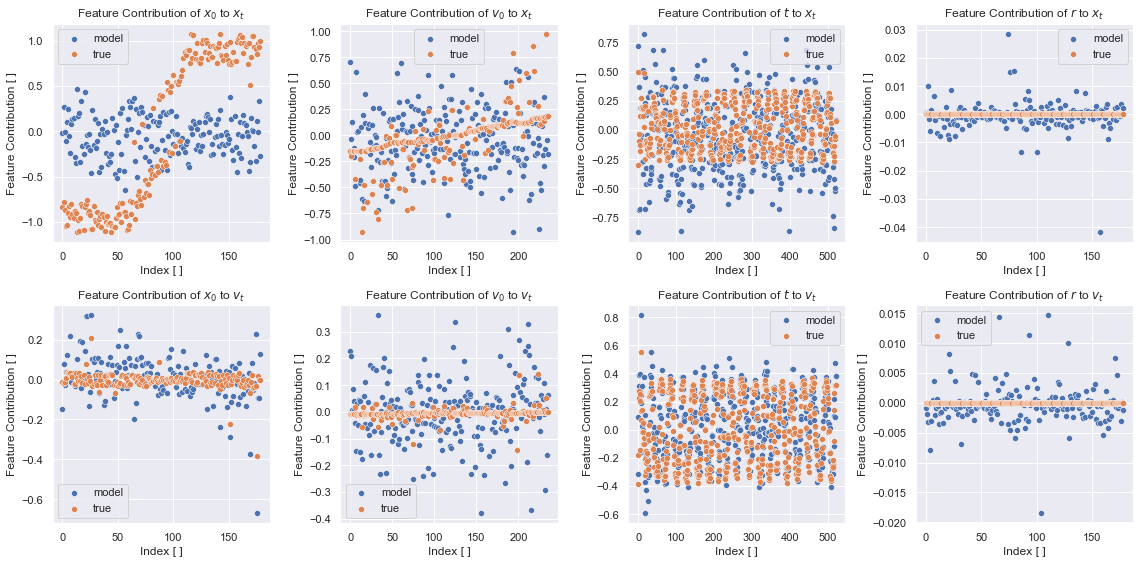

In [24]:
f, axs = plt.subplots(2, 4, figsize=(16, 8), gridspec_kw=dict(width_ratios=[4, 4, 4, 4]))

sns.scatterplot(data = plot_data_x0, x = plot_data_x0.index,  y='x0_xt', label = 'model', ax=axs[0,0])
sns.scatterplot(data = true_plot_data_x0, x = true_plot_data_x0.index,  y='x0_xt', label='true',ax=axs[0,0])
axs[0,0].set_title(r"Feature Contribution of $x_0$ to $x_t$")
axs[0,0].set_xlabel('Index [ ]')
axs[0,0].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = plot_data_v0, x = plot_data_v0.index,  y='v0_xt', label = 'model', ax=axs[0,1])
sns.scatterplot(data = true_plot_data_v0, x = true_plot_data_v0.index,  y='v0_xt', label='true',ax=axs[0,1])
axs[0,1].set_title(r"Feature Contribution of $v_0$ to $x_t$")
axs[0,1].set_xlabel('Index [ ]')
axs[0,1].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = plot_data_t, x = plot_data_t.index,  y='t_xt', label = 'model', ax=axs[0,2])
sns.scatterplot(data = true_plot_data_t, x = true_plot_data_t.index,  y='t_xt', label='true',ax=axs[0,2])
axs[0,2].set_title(r"Feature Contribution of $t$ to $x_t$")
axs[0,2].set_xlabel('Index [ ]')
axs[0,2].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = plot_data_x0, x = plot_data_x0.index,  y='x0_vt', label = 'model', ax=axs[1,0])
sns.scatterplot(data = true_plot_data_x0, x = true_plot_data_x0.index,  y='x0_vt', label='true',ax=axs[1,0])
axs[1,0].set_title(r"Feature Contribution of $x_0$ to $v_t$")
axs[1,0].set_xlabel('Index [ ]')
axs[1,0].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = plot_data_v0, x = plot_data_v0.index,  y='v0_vt', label = 'model', ax=axs[1,1])
sns.scatterplot(data = true_plot_data_v0, x = true_plot_data_v0.index,  y='v0_vt', label='true',ax=axs[1,1])
axs[1,1].set_title(r"Feature Contribution of $v_0$ to $v_t$")
axs[1,1].set_xlabel('Index [ ]')
axs[1,1].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = plot_data_t, x = plot_data_t.index,  y='t_vt', label = 'model', ax=axs[1,2])
sns.scatterplot(data = true_plot_data_t, x = true_plot_data_t.index,  y='t_vt', label='true',ax=axs[1,2])
axs[1,2].set_title(r"Feature Contribution of $t$ to $v_t$")
axs[1,2].set_xlabel('Index [ ]')
axs[1,2].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = plot_data_x0, x = plot_data_x0.index,  y='r1', label = 'model', ax=axs[0,3])
sns.scatterplot(data = true_plot_data_x0, x = true_plot_data_x0.index,  y='r1', label='true',ax=axs[0,3])
axs[0,3].set_title(r"Feature Contribution of $r$ to $x_t$")
axs[0,3].set_xlabel('Index [ ]')
axs[0,3].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = plot_data_x0, x = plot_data_x0.index,  y='r2', label = 'model', ax=axs[1,3])
sns.scatterplot(data = true_plot_data_x0, x = true_plot_data_x0.index,  y='r2', label='true',ax=axs[1,3])
axs[1,3].set_title(r"Feature Contribution of $r$ to $v_t$")
axs[1,3].set_xlabel('Index [ ]')
axs[1,3].set_ylabel('Feature Contribution [ ]')

f.tight_layout()

f.savefig("Images/shap_summary"+suffix+".svg", dpi='figure')

## Good Values
Only looking at good predictions: $|y_{pred}-y_{true}| < 0.1$

In [ ]:
"""
true_explainer = shap.explainers.Permutation(true_model.predict, background)
explainer = shap.explainers.Permutation(model.predict, background)

true_values = true_explainer(X_test_scale.iloc[:100,:])
model_values = explainer(X_test_scale.iloc[:100,:])
"""

In [40]:
vals = np.abs(np.linalg.norm(model.predict(X_test), axis=1)- np.linalg.norm(y_test, axis=1))

shap_data_good = X_test.iloc[np.where(vals < 0.0001)]

In [55]:
kernel_model_x0 = shap.KernelExplainer(model.predict, background)
kernel_model_values_x0 = kernel_model_x0.shap_values(shap_data_good)

Using 100000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/399 [00:00<?, ?it/s]

In [57]:
backgroundshap = shap.sample(X_train, 1000)

In [58]:
kernel_x0 = shap.KernelExplainer(true_model.predict, backgroundshap)
kernel_true_values_x0 = kernel_x0.shap_values(shap_data_good)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/399 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [43]:

kernel_true_values_x0_plot = pd.DataFrame(kernel_true_values_x0.values.reshape(-1, 2*np.shape(X_test.values)[1],order='F'), 
             columns = ['x0_xt','v0_xt', 't_xt','r1', 'x0_vt', 'v0_vt', 't_vt','r2'])

In [53]:
kernel_model_values_x0_plot

,x0_xt,v0_xt,t_xt,r1,x0_vt,v0_vt,t_vt,r2
0,-0.887827,-0.062017,0.293743,0.0,0.025908,-0.006098,-0.131025,0.0
1,-0.874374,-0.062017,-0.033789,0.0,-0.002540,-0.006098,0.322461,0.0
2,1.041188,-0.128966,-0.049638,0.0,0.004932,-0.009446,0.328277,0.0
3,-0.836134,-0.093262,0.273293,0.0,0.021033,0.010376,-0.142623,0.0
4,-0.845964,-0.097963,0.271028,0.0,-0.016405,-0.007529,0.141542,0.0
...,...,...,...,...,...,...,...,...
394,-0.625155,-0.349235,-0.186870,0.0,-0.017247,-0.016058,-0.241154,0.0
395,-1.019632,0.085012,0.087043,0.0,-0.008118,-0.003019,-0.355379,0.0
396,0.908039,0.049397,0.252904,0.0,0.005803,0.001402,0.218515,0.0
397,0.882809,0.045667,-0.244383,0.0,-0.011529,-0.002815,-0.019037,0.0


In [49]:
kernel_model_values_x0_plot = pd.DataFrame(kernel_model_values_x0.values.reshape(-1, 2*np.shape(X_test.values)[1],order='F'), 
             columns = ['x0_xt','v0_xt', 't_xt','r1', 'x0_vt', 'v0_vt', 't_vt','r2'])



In [45]:
kernel_true_values_x0_plot.to_csv("kernel_good_vals_only.csv")

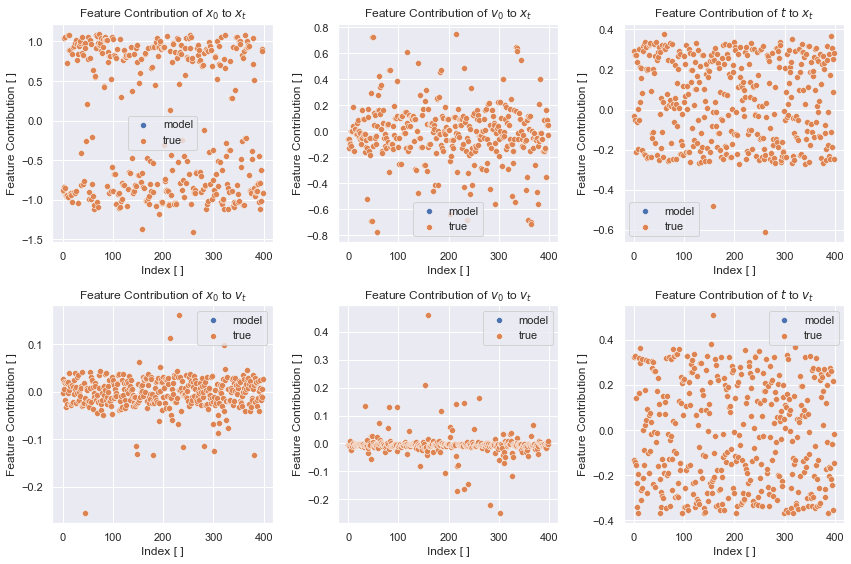

In [50]:
f, axs = plt.subplots(2, 3, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4, 4, 4]))

sns.scatterplot(data = kernel_model_values_x0_plot, x = kernel_model_values_x0_plot.index,  y='x0_xt', label = 'model', ax=axs[0,0])
sns.scatterplot(data = kernel_true_values_x0_plot, x = kernel_true_values_x0_plot.index,  y='x0_xt', label='true',ax=axs[0,0])
axs[0,0].set_title(r"Feature Contribution of $x_0$ to $x_t$")
axs[0,0].set_xlabel('Index [ ]')
axs[0,0].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = kernel_model_values_x0_plot, x = kernel_model_values_x0_plot.index,  y='v0_xt', label = 'model', ax=axs[0,1])
sns.scatterplot(data = kernel_true_values_x0_plot, x = kernel_true_values_x0_plot.index,  y='v0_xt', label='true',ax=axs[0,1])
axs[0,1].set_title(r"Feature Contribution of $v_0$ to $x_t$")
axs[0,1].set_xlabel('Index [ ]')
axs[0,1].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = kernel_model_values_x0_plot, x = kernel_model_values_x0_plot.index,  y='t_xt', label = 'model', ax=axs[0,2])
sns.scatterplot(data = kernel_true_values_x0_plot, x = kernel_true_values_x0_plot.index,  y='t_xt', label='true',ax=axs[0,2])
axs[0,2].set_title(r"Feature Contribution of $t$ to $x_t$")
axs[0,2].set_xlabel('Index [ ]')
axs[0,2].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = kernel_model_values_x0_plot, x = kernel_model_values_x0_plot.index,  y='x0_vt', label = 'model', ax=axs[1,0])
sns.scatterplot(data = kernel_true_values_x0_plot, x = kernel_true_values_x0_plot.index,  y='x0_vt', label='true',ax=axs[1,0])
axs[1,0].set_title(r"Feature Contribution of $x_0$ to $v_t$")
axs[1,0].set_xlabel('Index [ ]')
axs[1,0].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = kernel_model_values_x0_plot, x = kernel_model_values_x0_plot.index,  y='v0_vt', label = 'model', ax=axs[1,1])
sns.scatterplot(data = kernel_true_values_x0_plot, x = kernel_true_values_x0_plot.index,  y='v0_vt', label='true',ax=axs[1,1])
axs[1,1].set_title(r"Feature Contribution of $v_0$ to $v_t$")
axs[1,1].set_xlabel('Index [ ]')
axs[1,1].set_ylabel('Feature Contribution [ ]')

sns.scatterplot(data = kernel_model_values_x0_plot, x = kernel_model_values_x0_plot.index,  y='t_vt', label = 'model', ax=axs[1,2])
sns.scatterplot(data = kernel_true_values_x0_plot, x = kernel_true_values_x0_plot.index,  y='t_vt', label='true',ax=axs[1,2])
axs[1,2].set_title(r"Feature Contribution of $t$ to $v_t$")
axs[1,2].set_xlabel('Index [ ]')
axs[1,2].set_ylabel('Feature Contribution [ ]')

f.tight_layout()

f.savefig("Images/shap_summary"+suffix+"_good_values.svg", dpi='figure')

In [ ]:
def shap_aggregation_mean(x, model, scaler=scaler):
    x.values
    x.data
    x.base_values
    matrix = np.empty((len(x.values), 3, 3))
    aggregate = np.zeros((3,2))
    pred_values = model.predict(x.data)
    
    for i in range(len(x.values)):
        x_t_attribution = np.abs(x.values[i][:,0])
        v_t_attribution = np.abs(x.values[i][:,1])
        aggregate = aggregate + np.hstack((x_t_attribution.reshape((3,1)), v_t_attribution.reshape((3,1))))
        
    aggregate = aggregate/len(x.values)
    aggregate = pd.DataFrame(aggregate, columns = ['xt', 'vt'], index = ['x0','v0','t'])
    
    return matrix , aggregate

In [ ]:
true_matrix, true_aggregate = shap_aggregation_mean(true_values_partition, true_model)

model_matrix, model_aggregate = shap_aggregation_mean(model_values_partition, model)

In [ ]:
f, axs = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw=dict(width_ratios=[4, 4]))

sns.barplot(data = true_aggregate, x = true_aggregate.index,  y='xt', label = 'xt', ax=axs[0,0])
axs[0,0].set_title(r"Aggregate Feature Contribution to $x_t$ in the True Model")
axs[0,0].set_ylabel('Feature Contribution [ ]')

sns.barplot(data = true_aggregate, x = true_aggregate.index,  y='vt', label = 'vt', ax=axs[0,1])
axs[0,1].set_title(r"Aggregate Feature Contribution to $v_t$ in the True Model")
axs[0,1].set_ylabel('Feature Contribution [ ]')

sns.barplot(data = model_aggregate, x = true_aggregate.index,  y='xt', label = 'xt', ax=axs[1,0])
axs[1,0].set_title(r"Aggregate Feature Contribution to $x_t$ in the ML Model")
axs[1,0].set_ylabel('Feature Contribution [ ]')

sns.barplot(data = model_aggregate, x = model_aggregate.index,  y='vt', label = 'vt', ax=axs[1,1])
axs[1,1].set_title(r"Aggregate Feature Contribution to $v_t$ in the ML Model")
axs[1,1].set_ylabel('Feature Contribution [ ]')

f.tight_layout()

f.savefig("Images/shap_aggregated"+suffix+".svg", dpi='figure')

In [ ]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train_scale), verbose=True, mode='regression')

In [ ]:
i = 25
lime_exp_model = lime_explainer.explain_instance(X_test_scale.iloc[i], model.predict, num_features=3)
lime_exp_true = lime_explainer.explain_instance(X_test_scale.iloc[i], true_model.predict, num_features=3)

In [ ]:
lime_exp_model.show_in_notebook(show_table=True)

In [ ]:
lime_exp_true.show_in_notebook(show_table=True)

## An Analytic Approach to Explaining Feature Importance

In order to evaluate the usefulness of SHAP in explaining feature importance we need to determine what we would expect the explainer to give us.

The initial approach to doing this will be to take the gradient in each feature direction (x0,v0,t) at each point.

Since we cannot calculate the gradient analytically this will be done numerically.

To do so we take a point and calculate how much it shifts based on changing the input parameters:

$f(x_0+\delta,v_0,t) = (x,v),\quad f(x_0-\delta,v_0,t) = (x',v')  ,\quad \frac{df}{dx_0} = \frac{|(x',v')-(x,v)|}{\delta}$

In [ ]:
def num_grad(f, X, delta=0.01):
    """
        Numerical Gradient Calculation by Perturbing the 
        Inputs using a Central Finite Difference Method

        df/dx0 = |f(x0+delta,v0,t)-f(x0-delta,v0,t)|/(2*delta)

        Input
        ----------
        f : function to differentiate
        u : vector of length 2, (x,v)
            Position and Velocity at time t
        t : float, the time t

        Parameters
        ----------
        delta : float, perturbation

        Returns
        ----------
        [df/dx0,df/dv0] : Tuple, Derivatives of f by 
                    starting position and velocity

    """
    
    x01df = pd.DataFrame(np.array([X['x0']+delta, X['v0'],X['t']]), columns=['x0','v0','t'])
    x02df = pd.DataFrame(np.array([X['x0']-delta, X['v0'],X['t']]), columns=['x0','v0','t'])
    v01df = pd.DataFrame(np.array([X['x0'], X['v0']+delta,X['t']]), columns=['x0','v0','t'])
    v02df = pd.DataFrame(np.array([X['x0'], X['v0']-delta,X['t']]), columns=['x0','v0','t'])
    
    dx0 = (f(x01df) - f(x02df))/(2*delta)
    
    dv0 = (f(v01df) - f(v02df))/(2*delta)
    
    return pd.DataFrame(np.array([dx0, dv0]), columns=['dx0', 'dv0'])

In [ ]:
num_grad(true_model.predict, X, delta=0.01)

Notes:

Plan: 
    Finish gradient calc
    Plots:
            xt against x0, t, v0. individually. same for vt
            feature importance with x0 ordered etc
            